

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [40]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [41]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
%reload_ext autoreload

### Initial Parameters

In [43]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },    
    'pretrained_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':90},
        'lenet':{'dropout':0.2, 'epochs':90},
        'custom':{'dropout':0.2, 'epochs':90},
        'vgg':{'dropout':0.1, 'epochs':90},
        'resnet':{'dropout':0.2, 'epochs':90},
        'pretrained':{'dropout':0.2, 'epochs':20, 'learning_rate':0.0001}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
model_results.clear()

2022-08-18 20:24:42,252: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json


In [44]:
params.use_data_augmentation

False

## Get Data

### Download Data 

In [45]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [46]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

(1000, 32, 32, 3) (1000,)
(10000, 32, 32, 3) (10000,)


In [47]:
i = 0
image_folder_path = os.path.join(params.data_path, 'data', f'{data_name}_{params.train_image_count}')
if not os.path.exists(image_folder_path):
    os.makedirs(image_folder_path)
for class_ in params.classes:
    image_class_path = os.path.join(image_folder_path, class_)
    if not os.path.exists(image_class_path):
        os.makedirs(image_class_path)    
    
for train_image, train_label  in zip(train_images, train_labels):
    i = i + 1
    image = Image.fromarray(train_image)
    image_class_path = os.path.join(image_folder_path, f'{classes[train_label]}')
    image_path = os.path.join(image_class_path, f"{i}.png")
    image.save(image_path)    

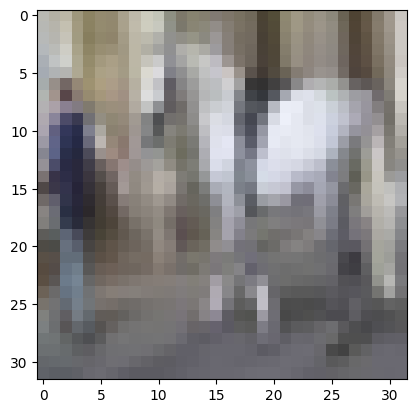

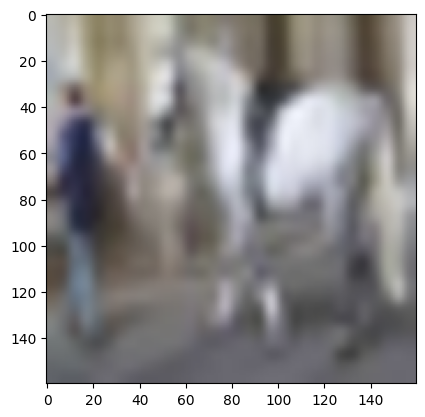

(32, 32, 3) (160, 160, 3)


In [9]:
def resize_image(image, shape=None):
    img = Image.fromarray(image)
    if shape is not None:
        img = img.resize(shape)
    image1 = np.asarray(img)
    return image1

def resize_images(images, shape=None):
    images1 = [resize_image(image, shape) for image in images]
    images1 = np.array(images1)
    return images1

input_shape=(160, 160) 
images = train_images[0:10]
images1 = resize_images(images, input_shape)

image_array = images[0]
plt.imshow(image_array)
plt.show()
 
image_array1 = images1[0]
plt.imshow(image_array1)
plt.show()

print(image_array.shape, image_array1.shape) 
# np.testing.assert_array_almost_equal(image_array, image_array1)

In [10]:
# train_images = resize_images(train_images, input_shape)
# test_images = resize_images(test_images, input_shape)

# print(train_images.shape, type(train_images), train_images.dtype)
# print(test_images.shape, type(test_images), test_images.dtype) 



### Data Explore 

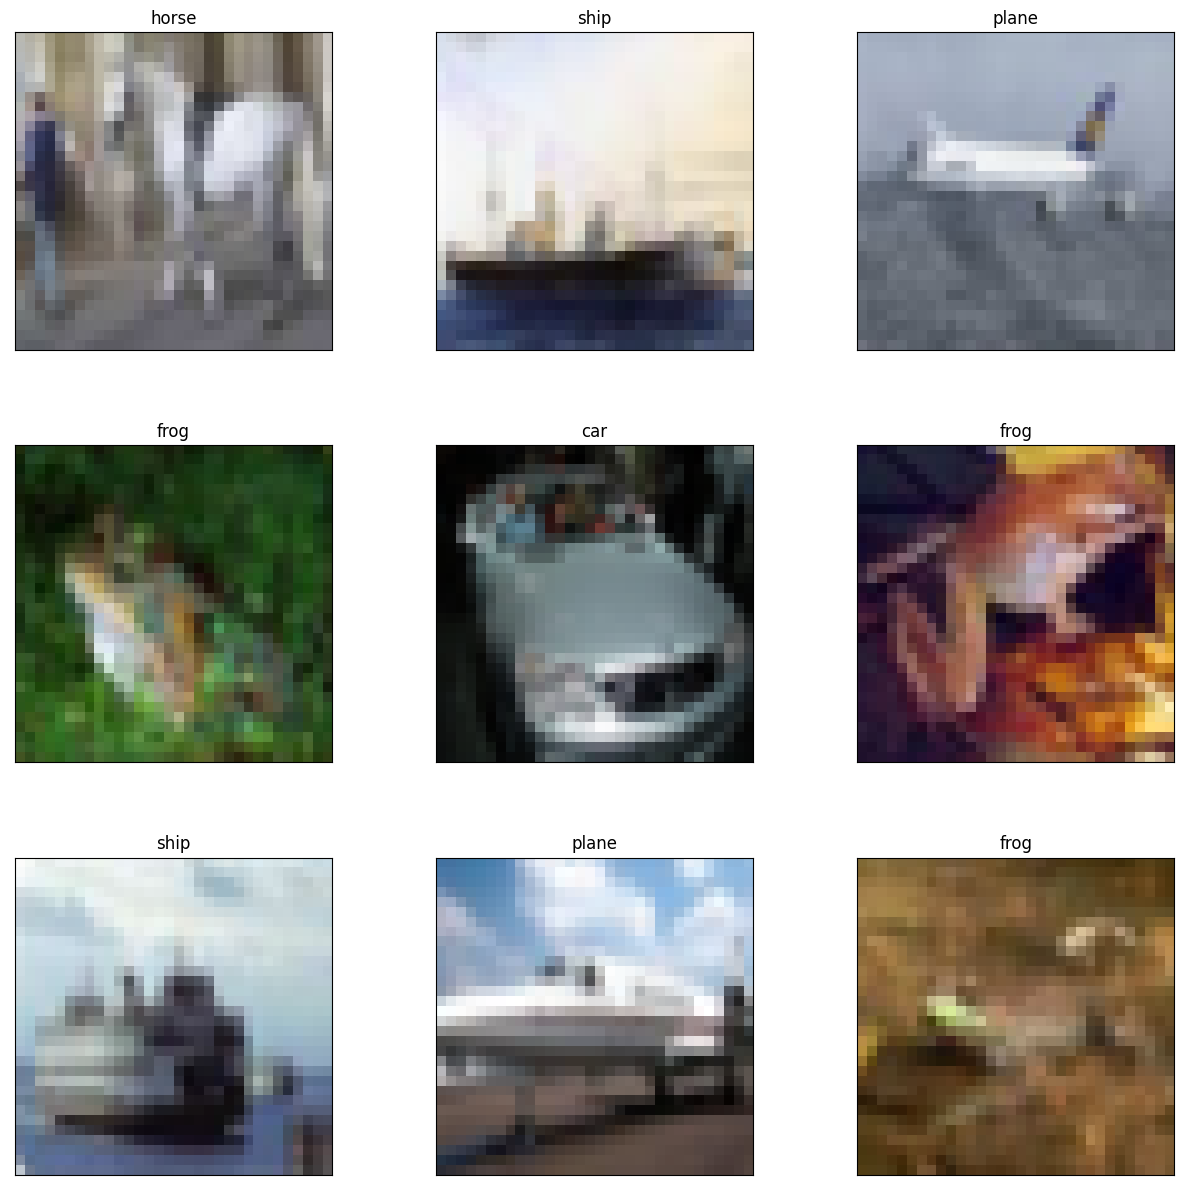

In [11]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

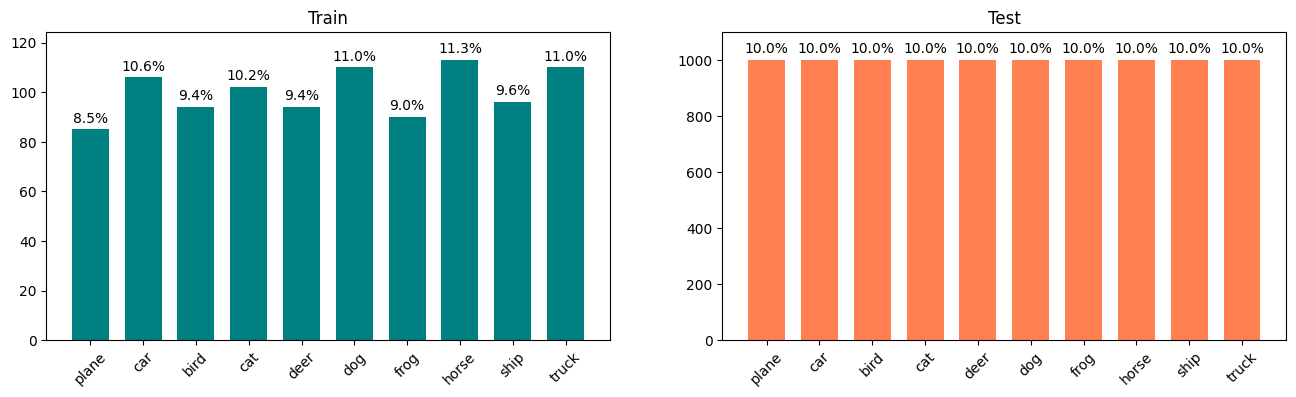

In [12]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [13]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [14]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [15]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

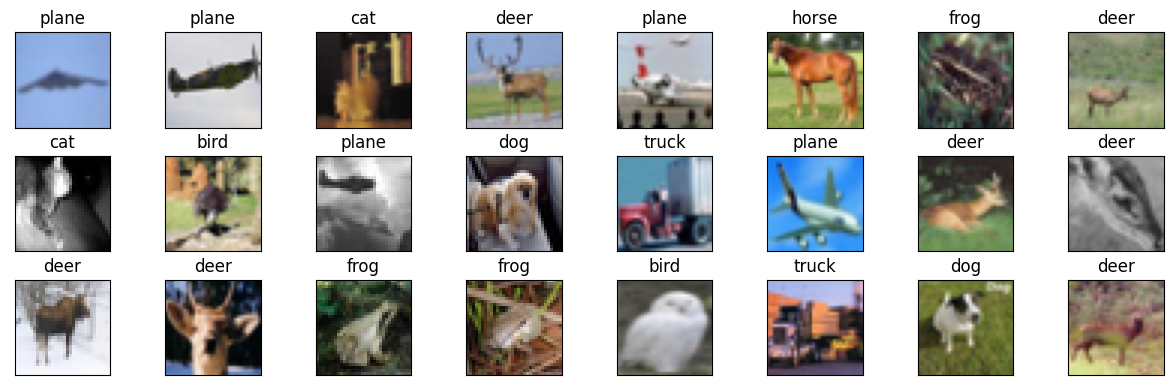

In [16]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [17]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

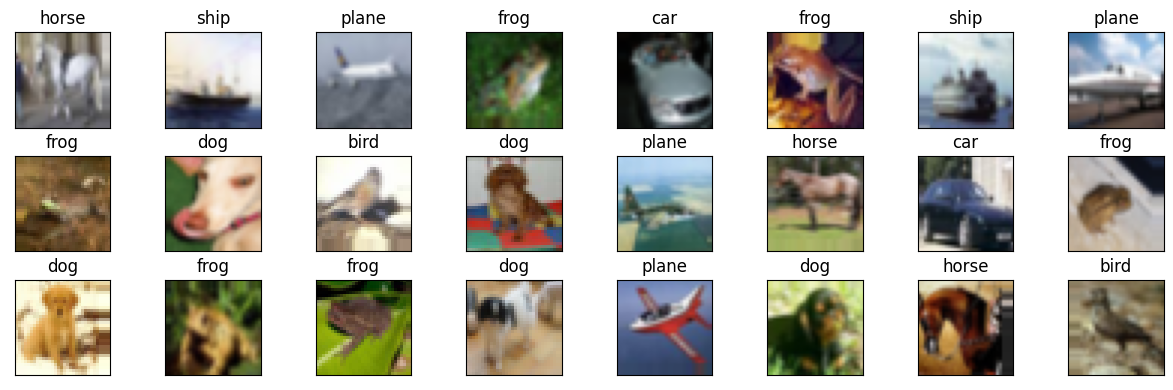

In [18]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

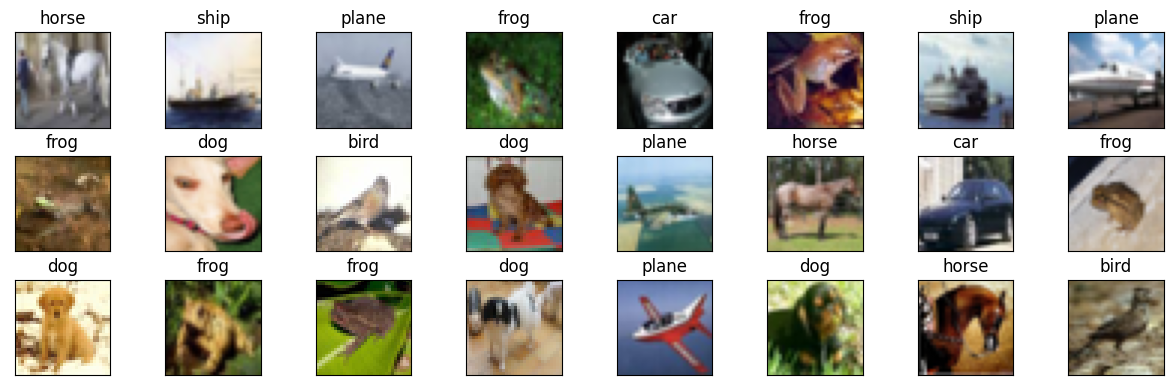

In [19]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [20]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [21]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


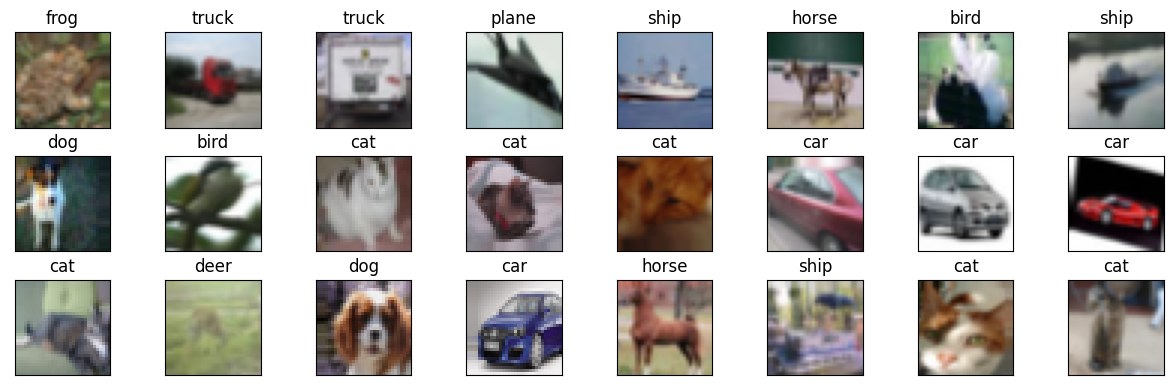

In [22]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [22]:
rescale = tf.keras.layers.Rescaling(1./255.0, offset=0)

### MLP

2022-08-16 08:57:26,203: INFO: model_params.mlp1.dropout=0.1
2022-08-16 08:57:26,204: INFO: model_params.mlp1.layer_count=1
2022-08-16 08:57:26,205: INFO: model_params.mlp1.units=128
2022-08-16 08:57:26,248: INFO: learning_rate=0.001
2022-08-16 08:57:26,249: INFO: model_params.mlp1.clip_value=None
2022-08-16 08:57:26,258: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable 

2022-08-16 08:57:26,274: INFO: model_params.mlp1.epochs=90
2022-08-16 08:57:26,274: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1, monitor=val_accuracy)
2022-08-16 08:57:26,275: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 08:57:26,276: INFO: use LearningRateScheduler()
2022-08-16 08:57:26,276: INFO: steps_per_epoch=31
2022-08-16 08:57:26,277: INFO: start training
2022-08-16 08:57:26,278: INFO: use_class_weight=False


Epoch 1/90
22/31 [====================>.........] - ETA: 0s - loss: 2.6259 - accuracy: 0.1250 INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:57:28,709: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 2s 55ms/step - loss: 2.5207 - accuracy: 0.1230 - val_loss: 2.2238 - val_accuracy: 0.1493 - lr: 0.0010
Epoch 2/90
21/31 [===================>..........] - ETA: 0s - loss: 2.1350 - accuracy: 0.2128INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:57:30,130: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 47ms/step - loss: 2.1213 - accuracy: 0.2298 - val_loss: 2.0992 - val_accuracy: 0.2535 - lr: 0.0010
Epoch 3/90
19/31 [=================>............] - ETA: 0s - loss: 2.0247 - accuracy: 0.2582INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:57:31,586: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 48ms/step - loss: 2.0165 - accuracy: 0.2651 - val_loss: 2.0369 - val_accuracy: 0.2832 - lr: 0.0010
Epoch 4/90
31/31 [==============================] - 1s 24ms/step - loss: 1.9743 - accuracy: 0.2772 - val_loss: 2.0112 - val_accuracy: 0.2790 - lr: 0.0010
Epoch 5/90
31/31 [==============================] - 1s 24ms/step - loss: 1.9150 - accuracy: 0.3145 - val_loss: 1.9704 - val_accuracy: 0.2722 - lr: 0.0010
Epoch 6/90
21/31 [===================>..........] - ETA: 0s - loss: 1.8790 - accuracy: 0.2976INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:57:34,482: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 48ms/step - loss: 1.8820 - accuracy: 0.3125 - val_loss: 1.9717 - val_accuracy: 0.2986 - lr: 0.0010
Epoch 7/90
31/31 [==============================] - 1s 24ms/step - loss: 1.8496 - accuracy: 0.3427 - val_loss: 1.9684 - val_accuracy: 0.2866 - lr: 0.0010
Epoch 8/90
21/31 [===================>..........] - ETA: 0s - loss: 1.8197 - accuracy: 0.3557INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:57:37,325: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 2s 70ms/step - loss: 1.8128 - accuracy: 0.3528 - val_loss: 1.9528 - val_accuracy: 0.3034 - lr: 0.0010
Epoch 9/90
22/31 [====================>.........] - ETA: 0s - loss: 1.7653 - accuracy: 0.3665INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:57:38,703: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 46ms/step - loss: 1.7833 - accuracy: 0.3659 - val_loss: 1.9123 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 10/90
31/31 [==============================] - 1s 21ms/step - loss: 1.7367 - accuracy: 0.3851 - val_loss: 1.9326 - val_accuracy: 0.3165 - lr: 0.0010
Epoch 11/90
31/31 [==============================] - 1s 21ms/step - loss: 1.7021 - accuracy: 0.4143 - val_loss: 1.9540 - val_accuracy: 0.3076 - lr: 0.0010
Epoch 12/90
31/31 [==============================] - 1s 21ms/step - loss: 1.6989 - accuracy: 0.3972 - val_loss: 1.9505 - val_accuracy: 0.3188 - lr: 0.0010
Epoch 13/90
31/31 [==============================] - 1s 20ms/step - loss: 1.6641 - accuracy: 0.4113 - val_loss: 1.9453 - val_accuracy: 0.3175 - lr: 0.0010
Epoch 14/90
31/31 [==============================] - 1s 20ms/step - loss: 1.6447 - accuracy: 0.4294 - val_loss: 1.9662 - val_accuracy: 0.3173 - lr: 0.0010
Epoch 15/90
31/31 [==============================] - 1s 20ms/step - loss: 1.6164 -

2022-08-16 08:57:44,047: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 2s 52ms/step - loss: 1.5857 - accuracy: 0.4546 - val_loss: 1.9088 - val_accuracy: 0.3354 - lr: 0.0010
Epoch 17/90
31/31 [==============================] - 1s 22ms/step - loss: 1.5691 - accuracy: 0.4587 - val_loss: 1.9298 - val_accuracy: 0.3284 - lr: 0.0010
Epoch 18/90
31/31 [==============================] - 1s 21ms/step - loss: 1.5393 - accuracy: 0.4829 - val_loss: 1.9178 - val_accuracy: 0.3302 - lr: 0.0010
Epoch 19/90
31/31 [==============================] - 1s 21ms/step - loss: 1.5482 - accuracy: 0.4738 - val_loss: 1.9875 - val_accuracy: 0.3199 - lr: 0.0010
Epoch 20/90
31/31 [==============================] - 1s 20ms/step - loss: 1.5472 - accuracy: 0.4657 - val_loss: 1.9650 - val_accuracy: 0.3254 - lr: 0.0010
Epoch 21/90
31/31 [==============================] - 1s 21ms/step - loss: 1.5161 - accuracy: 0.4778 - val_loss: 1.9733 - val_accuracy: 0.3218 - lr: 0.0010
Epoch 22/90
31/31 [==============================] - 1s 21ms/step - loss: 1.5156 -

2022-08-16 08:57:55,745: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 47ms/step - loss: 1.3479 - accuracy: 0.5383 - val_loss: 1.9236 - val_accuracy: 0.3360 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/90
22/31 [====================>.........] - ETA: 0s - loss: 1.2591 - accuracy: 0.6009INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:57:57,153: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 47ms/step - loss: 1.2835 - accuracy: 0.5837 - val_loss: 1.9270 - val_accuracy: 0.3374 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/90
31/31 [==============================] - 1s 23ms/step - loss: 1.2824 - accuracy: 0.5524 - val_loss: 1.9255 - val_accuracy: 0.3367 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/90
31/31 [==============================] - 1s 24ms/step - loss: 1.2660 - accuracy: 0.5766 - val_loss: 1.9242 - val_accuracy: 0.3349 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/90
20/31 [==================>...........] - ETA: 0s - loss: 1.2594 - accuracy: 0.5766INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:57:59,994: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 47ms/step - loss: 1.2696 - accuracy: 0.5756 - val_loss: 1.9219 - val_accuracy: 0.3377 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/90
31/31 [==============================] - 1s 23ms/step - loss: 1.2521 - accuracy: 0.5867 - val_loss: 1.9271 - val_accuracy: 0.3350 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/90
22/31 [====================>.........] - ETA: 0s - loss: 1.2331 - accuracy: 0.5852INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:58:02,128: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 47ms/step - loss: 1.2504 - accuracy: 0.5857 - val_loss: 1.9230 - val_accuracy: 0.3392 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/90
31/31 [==============================] - 1s 23ms/step - loss: 1.2500 - accuracy: 0.5806 - val_loss: 1.9238 - val_accuracy: 0.3380 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/90
22/31 [====================>.........] - ETA: 0s - loss: 1.2123 - accuracy: 0.5966INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:58:04,271: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 47ms/step - loss: 1.2370 - accuracy: 0.5837 - val_loss: 1.9277 - val_accuracy: 0.3394 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/90
19/31 [=================>............] - ETA: 0s - loss: 1.2443 - accuracy: 0.5822INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:58:05,754: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 49ms/step - loss: 1.2399 - accuracy: 0.5806 - val_loss: 1.9326 - val_accuracy: 0.3400 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/90
23/31 [=====================>........] - ETA: 0s - loss: 1.2257 - accuracy: 0.5965INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:58:07,088: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 44ms/step - loss: 1.2405 - accuracy: 0.5998 - val_loss: 1.9311 - val_accuracy: 0.3407 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/90
31/31 [==============================] - 1s 21ms/step - loss: 1.2228 - accuracy: 0.6018 - val_loss: 1.9338 - val_accuracy: 0.3379 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/90
31/31 [==============================] - 1s 22ms/step - loss: 1.2097 - accuracy: 0.5988 - val_loss: 1.9345 - val_accuracy: 0.3377 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/90
31/31 [==============================] - 1s 21ms/step - loss: 1.1998 - accuracy: 0.6028 - val_loss: 1.9451 - val_accuracy: 0.3380 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/90
24/31 [======================>.......] - ETA: 0s - loss: 1.1830 - accuracy: 0.6198
Epoch 46: ReduceLROnP

2022-08-16 08:58:11,198: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 2s 51ms/step - loss: 1.1613 - accuracy: 0.6250 - val_loss: 1.9462 - val_accuracy: 0.3412 - lr: 1.0000e-04
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/90
31/31 [==============================] - 1s 21ms/step - loss: 1.1748 - accuracy: 0.6119 - val_loss: 1.9484 - val_accuracy: 0.3393 - lr: 1.0000e-04
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/90
24/31 [======================>.......] - ETA: 0s - loss: 1.1702 - accuracy: 0.6120INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:58:13,443: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 2s 54ms/step - loss: 1.1773 - accuracy: 0.6129 - val_loss: 1.9385 - val_accuracy: 0.3413 - lr: 1.0000e-04
Epoch 00050: Still keep learning rate 0.0001 instead of 0.001
Epoch 50/90
31/31 [==============================] - 1s 23ms/step - loss: 1.1719 - accuracy: 0.6190 - val_loss: 1.9417 - val_accuracy: 0.3377 - lr: 1.0000e-04
Epoch 00051: Still keep learning rate 0.0001 instead of 0.001
Epoch 51/90
31/31 [==============================] - 1s 20ms/step - loss: 1.1685 - accuracy: 0.6149 - val_loss: 1.9438 - val_accuracy: 0.3403 - lr: 1.0000e-04
Epoch 00052: Still keep learning rate 0.0001 instead of 0.001
Epoch 52/90
24/31 [======================>.......] - ETA: 0s - loss: 1.1573 - accuracy: 0.6159INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


2022-08-16 08:58:16,073: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 44ms/step - loss: 1.1506 - accuracy: 0.6240 - val_loss: 1.9473 - val_accuracy: 0.3415 - lr: 1.0000e-04
Epoch 00053: Still keep learning rate 0.0001 instead of 0.001
Epoch 53/90
31/31 [==============================] - 1s 20ms/step - loss: 1.1641 - accuracy: 0.6230 - val_loss: 1.9444 - val_accuracy: 0.3387 - lr: 1.0000e-04
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
Epoch 54/90
31/31 [==============================] - 1s 21ms/step - loss: 1.1767 - accuracy: 0.6149 - val_loss: 1.9468 - val_accuracy: 0.3405 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/90
31/31 [==============================] - 1s 22ms/step - loss: 1.1664 - accuracy: 0.6280 - val_loss: 1.9480 - val_accuracy: 0.3403 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/90
31/31 [==============================] - 1s 24ms/step - loss: 1.1435 - accuracy: 0.6270 - val_loss: 1.9413 - val_acc

2022-08-16 08:58:20,086: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1/assets


31/31 [==============================] - 1s 45ms/step - loss: 1.1594 - accuracy: 0.6139 - val_loss: 1.9446 - val_accuracy: 0.3416 - lr: 1.0000e-04
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
Epoch 58/90
31/31 [==============================] - 1s 24ms/step - loss: 1.1534 - accuracy: 0.6169 - val_loss: 1.9476 - val_accuracy: 0.3391 - lr: 1.0000e-04
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
Epoch 59/90
31/31 [==============================] - 1s 23ms/step - loss: 1.1708 - accuracy: 0.6260 - val_loss: 1.9430 - val_accuracy: 0.3388 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/90
31/31 [==============================] - 1s 23ms/step - loss: 1.1138 - accuracy: 0.6351 - val_loss: 1.9515 - val_accuracy: 0.3391 - lr: 1.0000e-04
Epoch 61/90
23/31 [=====================>........] - ETA: 0s - loss: 1.1339 - accuracy: 0.6359
Epoch 61: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
31/31 [==========

2022-08-16 08:58:42,501: INFO: finish training [elapsed time: 76.22 seconds]


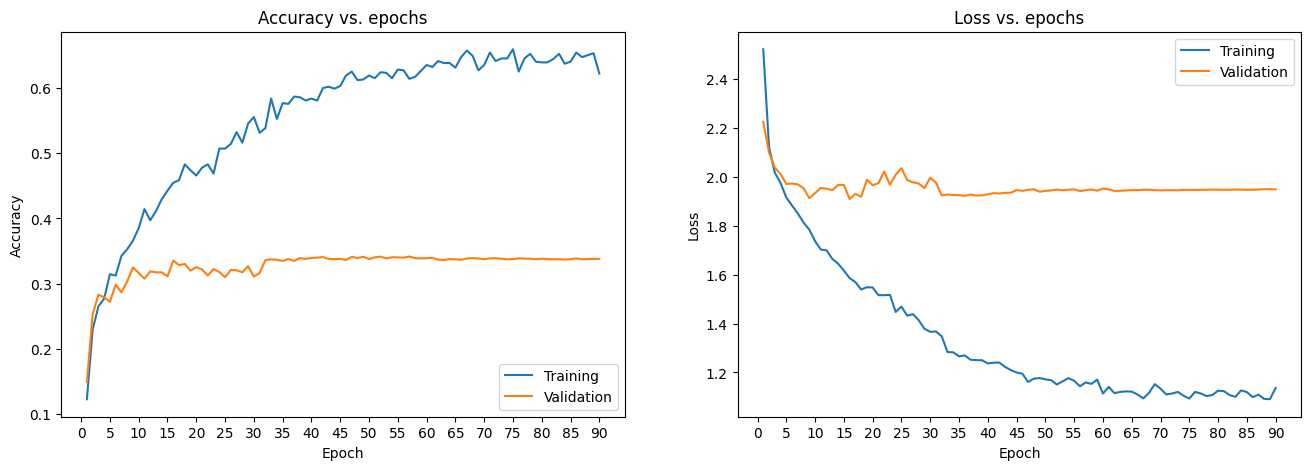

2022-08-16 08:58:42,986: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 0s 1ms/step


2022-08-16 08:58:45,470: INFO: test loss:1.9446
2022-08-16 08:58:45,470: INFO: test accuracy:0.3416
2022-08-16 08:58:45,472: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-16 08:58:45,473: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-16 08:58:45,474: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator
2022-08-16 08:58:45,475: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 0s 1ms/step


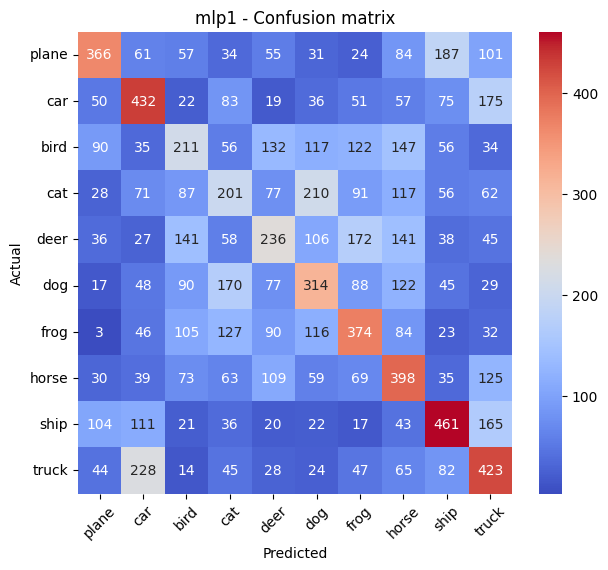

----------------------------------------models----------------------------------------


model_name                program_name  weight_number  train_time  \
1       mlp1  cifar10_0816_cnt_100.ipynb         394634        76.2   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 08:58      1.0599     1.9446            0.69         0.3416   

   train_auc  test_auc  
1     0.9469    0.7775

In [23]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-08-16 08:58:46,925: INFO: model_params.lenet1.dropout=0.2
2022-08-16 08:58:47,040: INFO: learning_rate=0.001
2022-08-16 08:58:47,041: INFO: model_params.lenet1.clip_value=None
2022-08-16 08:58:47,047: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0    

2022-08-16 08:58:47,080: INFO: model_params.lenet1.epochs=90
2022-08-16 08:58:47,081: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1, monitor=val_accuracy)
2022-08-16 08:58:47,082: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 08:58:47,083: INFO: use LearningRateScheduler()
2022-08-16 08:58:47,083: INFO: steps_per_epoch=31
2022-08-16 08:58:47,084: INFO: start training
2022-08-16 08:58:47,084: INFO: use_class_weight=False


Epoch 1/90
31/31 [==============================] - ETA: 0s - loss: 2.6025 - accuracy: 0.1190

2022-08-16 08:58:51,419: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:58:52,051: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 5s 110ms/step - loss: 2.6025 - accuracy: 0.1190 - val_loss: 2.2772 - val_accuracy: 0.1412 - lr: 0.0010
Epoch 2/90
25/31 [=======================>......] - ETA: 0s - loss: 2.2089 - accuracy: 0.2100

2022-08-16 08:58:54,328: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:58:54,947: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 96ms/step - loss: 2.1859 - accuracy: 0.2167 - val_loss: 2.2221 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 3/90
31/31 [==============================] - 1s 30ms/step - loss: 2.0044 - accuracy: 0.2994 - val_loss: 2.2284 - val_accuracy: 0.1283 - lr: 0.0010
Epoch 4/90
31/31 [==============================] - 1s 33ms/step - loss: 1.8837 - accuracy: 0.3185 - val_loss: 2.1571 - val_accuracy: 0.1690 - lr: 0.0010
Epoch 5/90
31/31 [==============================] - 1s 34ms/step - loss: 1.8028 - accuracy: 0.3518 - val_loss: 2.1225 - val_accuracy: 0.1784 - lr: 0.0010
Epoch 6/90
30/31 [============================>.] - ETA: 0s - loss: 1.6903 - accuracy: 0.3948

2022-08-16 08:59:00,285: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:59:00,939: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 101ms/step - loss: 1.6921 - accuracy: 0.3952 - val_loss: 2.0324 - val_accuracy: 0.2450 - lr: 0.0010
Epoch 7/90
31/31 [==============================] - 1s 34ms/step - loss: 1.6240 - accuracy: 0.4022 - val_loss: 2.1166 - val_accuracy: 0.2249 - lr: 0.0010
Epoch 8/90
29/31 [===========================>..] - ETA: 0s - loss: 1.6203 - accuracy: 0.4138

2022-08-16 08:59:04,614: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:59:05,369: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 112ms/step - loss: 1.6166 - accuracy: 0.4123 - val_loss: 1.9246 - val_accuracy: 0.3062 - lr: 0.0010
Epoch 9/90
31/31 [==============================] - 1s 33ms/step - loss: 1.4773 - accuracy: 0.4748 - val_loss: 1.9354 - val_accuracy: 0.2991 - lr: 0.0010
Epoch 10/90
23/31 [=====================>........] - ETA: 0s - loss: 1.4292 - accuracy: 0.4851

2022-08-16 08:59:08,631: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:59:09,239: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 95ms/step - loss: 1.4599 - accuracy: 0.4698 - val_loss: 1.9726 - val_accuracy: 0.3111 - lr: 0.0010
Epoch 11/90
31/31 [==============================] - ETA: 0s - loss: 1.3621 - accuracy: 0.4960

2022-08-16 08:59:11,581: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:59:12,193: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 98ms/step - loss: 1.3621 - accuracy: 0.4960 - val_loss: 1.8021 - val_accuracy: 0.3637 - lr: 0.0010
Epoch 12/90
31/31 [==============================] - 1s 36ms/step - loss: 1.3317 - accuracy: 0.5292 - val_loss: 1.9179 - val_accuracy: 0.3309 - lr: 0.0010
Epoch 13/90
31/31 [==============================] - 1s 34ms/step - loss: 1.2076 - accuracy: 0.5887 - val_loss: 1.9818 - val_accuracy: 0.3293 - lr: 0.0010
Epoch 14/90
31/31 [==============================] - 1s 32ms/step - loss: 1.2585 - accuracy: 0.5514 - val_loss: 2.0105 - val_accuracy: 0.3233 - lr: 0.0010
Epoch 15/90
31/31 [==============================] - 1s 31ms/step - loss: 1.1921 - accuracy: 0.5837 - val_loss: 1.8780 - val_accuracy: 0.3586 - lr: 0.0010
Epoch 16/90
23/31 [=====================>........] - ETA: 0s - loss: 1.0921 - accuracy: 0.6196

2022-08-16 08:59:18,861: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:59:19,483: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 109ms/step - loss: 1.1018 - accuracy: 0.6058 - val_loss: 1.8624 - val_accuracy: 0.3784 - lr: 0.0010
Epoch 17/90
31/31 [==============================] - 1s 34ms/step - loss: 1.0333 - accuracy: 0.6290 - val_loss: 1.9974 - val_accuracy: 0.3549 - lr: 0.0010
Epoch 18/90
31/31 [==============================] - 1s 35ms/step - loss: 1.0118 - accuracy: 0.6421 - val_loss: 2.0925 - val_accuracy: 0.3483 - lr: 0.0010
Epoch 19/90
31/31 [==============================] - 1s 34ms/step - loss: 0.9898 - accuracy: 0.6442 - val_loss: 1.9311 - val_accuracy: 0.3752 - lr: 0.0010
Epoch 20/90
29/31 [===========================>..] - ETA: 0s - loss: 0.8912 - accuracy: 0.6918

2022-08-16 08:59:24,962: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:59:25,649: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 101ms/step - loss: 0.8949 - accuracy: 0.6915 - val_loss: 1.9361 - val_accuracy: 0.3900 - lr: 0.0010
Epoch 21/90
31/31 [==============================] - 1s 34ms/step - loss: 0.8575 - accuracy: 0.7087 - val_loss: 2.0967 - val_accuracy: 0.3693 - lr: 0.0010
Epoch 22/90
31/31 [==============================] - 1s 32ms/step - loss: 0.8277 - accuracy: 0.7137 - val_loss: 2.0084 - val_accuracy: 0.3878 - lr: 0.0010
Epoch 23/90
22/31 [====================>.........] - ETA: 0s - loss: 0.9037 - accuracy: 0.6974

2022-08-16 08:59:30,147: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:59:30,845: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 106ms/step - loss: 0.8761 - accuracy: 0.7046 - val_loss: 1.9375 - val_accuracy: 0.3945 - lr: 0.0010
Epoch 24/90
31/31 [==============================] - 1s 34ms/step - loss: 0.7401 - accuracy: 0.7560 - val_loss: 2.0716 - val_accuracy: 0.3792 - lr: 0.0010
Epoch 25/90
30/31 [============================>.] - ETA: 0s - loss: 0.7210 - accuracy: 0.7448

2022-08-16 08:59:34,487: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:59:35,145: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 109ms/step - loss: 0.7193 - accuracy: 0.7460 - val_loss: 2.0679 - val_accuracy: 0.4021 - lr: 0.0010
Epoch 26/90
31/31 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.7288
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
31/31 [==============================] - 1s 35ms/step - loss: 0.7518 - accuracy: 0.7288 - val_loss: 2.1834 - val_accuracy: 0.3747 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/90
31/31 [==============================] - 1s 33ms/step - loss: 0.6619 - accuracy: 0.7611 - val_loss: 2.0442 - val_accuracy: 0.4021 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
23/31 [=====================>........] - ETA: 0s - loss: 0.6158 - accuracy: 0.7840

2022-08-16 08:59:39,519: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:59:40,171: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 97ms/step - loss: 0.6464 - accuracy: 0.7732 - val_loss: 2.0519 - val_accuracy: 0.4054 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/90
31/31 [==============================] - 1s 33ms/step - loss: 0.5662 - accuracy: 0.8135 - val_loss: 2.1067 - val_accuracy: 0.3946 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/90
31/31 [==============================] - 1s 35ms/step - loss: 0.5786 - accuracy: 0.8105 - val_loss: 2.0671 - val_accuracy: 0.3949 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/90
31/31 [==============================] - 1s 34ms/step - loss: 0.5649 - accuracy: 0.7984 - val_loss: 2.1403 - val_accuracy: 0.3956 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
31/31 [==============================] - 1s 35ms/step - loss: 0.5380 - accuracy: 0.8044 - val_loss: 2.15

2022-08-16 08:59:53,692: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:59:54,338: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 100ms/step - loss: 0.4564 - accuracy: 0.8387 - val_loss: 2.1848 - val_accuracy: 0.4069 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/90
31/31 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.8387
Epoch 41: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
31/31 [==============================] - 1s 34ms/step - loss: 0.4517 - accuracy: 0.8387 - val_loss: 2.1988 - val_accuracy: 0.4050 - lr: 1.0000e-04
Epoch 00042: Still keep learning rate 0.0001 instead of 0.001
Epoch 42/90
29/31 [===========================>..] - ETA: 0s - loss: 0.4421 - accuracy: 0.8534

2022-08-16 08:59:58,017: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 08:59:58,636: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 108ms/step - loss: 0.4539 - accuracy: 0.8478 - val_loss: 2.2294 - val_accuracy: 0.4093 - lr: 1.0000e-04
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
Epoch 43/90
31/31 [==============================] - 1s 35ms/step - loss: 0.4260 - accuracy: 0.8558 - val_loss: 2.2397 - val_accuracy: 0.4063 - lr: 1.0000e-04
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
Epoch 44/90
31/31 [==============================] - ETA: 0s - loss: 0.4292 - accuracy: 0.8599

2022-08-16 09:00:02,180: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


2022-08-16 09:00:02,798: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1/assets


31/31 [==============================] - 3s 103ms/step - loss: 0.4292 - accuracy: 0.8599 - val_loss: 2.2138 - val_accuracy: 0.4099 - lr: 1.0000e-04
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
Epoch 45/90
31/31 [==============================] - 1s 34ms/step - loss: 0.4403 - accuracy: 0.8407 - val_loss: 2.2263 - val_accuracy: 0.4097 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/90
31/31 [==============================] - 1s 35ms/step - loss: 0.4372 - accuracy: 0.8498 - val_loss: 2.2360 - val_accuracy: 0.4098 - lr: 1.0000e-04
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/90
31/31 [==============================] - 1s 33ms/step - loss: 0.4340 - accuracy: 0.8518 - val_loss: 2.2363 - val_accuracy: 0.4040 - lr: 1.0000e-04
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/90
31/31 [==============================] - 1s 35ms/step - loss: 0.3700 - accuracy: 0.8760 - val_loss: 2.2483 - val_ac

31/31 [==============================] - 1s 30ms/step - loss: 0.3232 - accuracy: 0.8831 - val_loss: 2.3877 - val_accuracy: 0.3994 - lr: 3.1623e-05
Epoch 00084: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 84/90
31/31 [==============================] - 1s 31ms/step - loss: 0.3051 - accuracy: 0.8911 - val_loss: 2.3939 - val_accuracy: 0.3998 - lr: 3.1623e-05
Epoch 00085: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 85/90
31/31 [==============================] - 1s 35ms/step - loss: 0.2644 - accuracy: 0.9133 - val_loss: 2.4084 - val_accuracy: 0.3984 - lr: 3.1623e-05
Epoch 00086: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 86/90
23/31 [=====================>........] - ETA: 0s - loss: 0.2964 - accuracy: 0.9049
Epoch 86: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
31/31 [==============================] - 1s 31ms/step - loss: 0.3064 - accuracy: 0.9012 - val_loss: 2.4211 - val_accuracy: 0.3982 - lr: 1.0000e-05
Epoch 00087: Still ke

2022-08-16 09:00:48,888: INFO: finish training [elapsed time: 121.80 seconds]


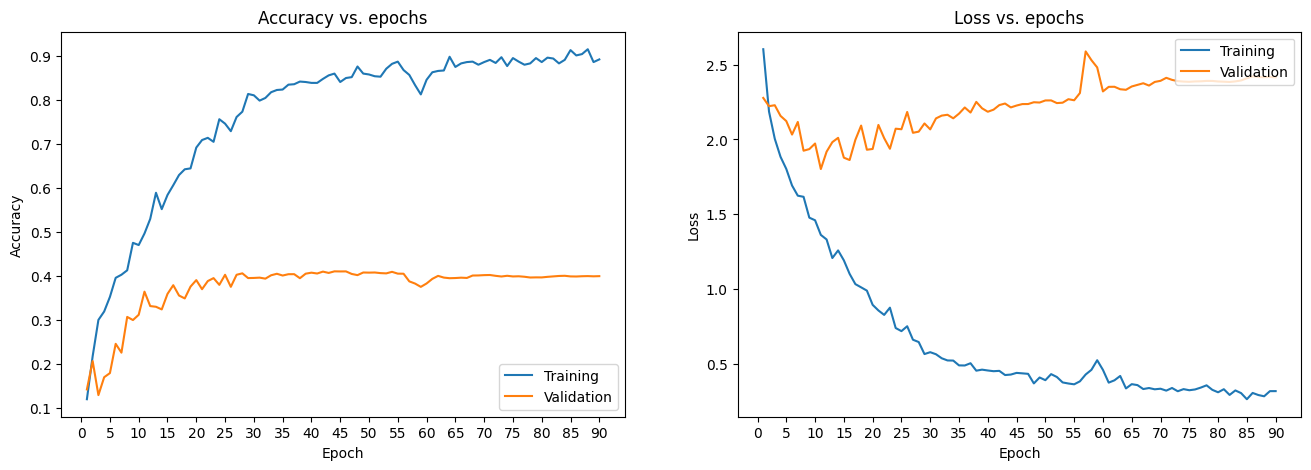

2022-08-16 09:00:49,402: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-16 09:00:53,252: INFO: test loss:2.2138
2022-08-16 09:00:53,253: INFO: test accuracy:0.4099
2022-08-16 09:00:53,255: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-16 09:00:53,257: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-16 09:00:53,257: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator
2022-08-16 09:00:53,259: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator
2022-08-16 09:00:53,260: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/mlp1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:00:53,895: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator


313/313 [==============================] - 0s 1ms/step


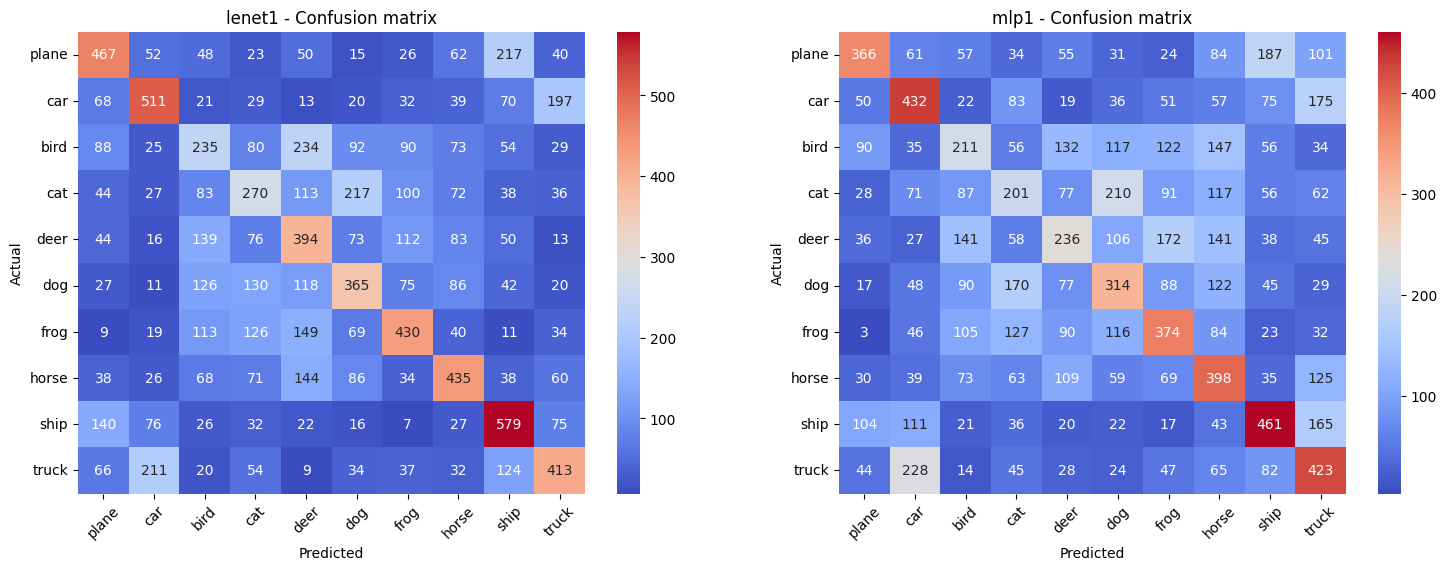

----------------------------------------models----------------------------------------


model_name                program_name  weight_number  train_time  \
1     lenet1  cifar10_0816_cnt_100.ipynb          83170       121.8   
2       mlp1  cifar10_0816_cnt_100.ipynb         394634        76.2   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 09:00      0.1353     2.2138           0.983         0.4099   
2  2022-08-16 08:58      1.0599     1.9446           0.690         0.3416   

   train_auc  test_auc  
1     0.9988    0.8232  
2     0.9469    0.7775

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


2022-08-16 09:00:57,330: INFO: model_params.custom1.dropout=0.2
2022-08-16 09:00:57,437: INFO: learning_rate=0.001
2022-08-16 09:00:57,438: INFO: model_params.custom1.clip_value=None
2022-08-16 09:00:57,444: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0   

2022-08-16 09:00:57,476: INFO: model_params.custom1.epochs=90
2022-08-16 09:00:57,477: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1, monitor=val_accuracy)
2022-08-16 09:00:57,477: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:00:57,478: INFO: use LearningRateScheduler()
2022-08-16 09:00:57,479: INFO: steps_per_epoch=31
2022-08-16 09:00:57,479: INFO: start training
2022-08-16 09:00:57,480: INFO: use_class_weight=False


Epoch 1/90
22/31 [====================>.........] - ETA: 0s - loss: 2.8353 - accuracy: 0.1705

2022-08-16 09:01:01,129: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:01,813: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 4s 116ms/step - loss: 2.7107 - accuracy: 0.1593 - val_loss: 2.2989 - val_accuracy: 0.1044 - lr: 0.0010
Epoch 2/90
23/31 [=====================>........] - ETA: 0s - loss: 2.1940 - accuracy: 0.2188

2022-08-16 09:01:04,910: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:05,714: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 4s 130ms/step - loss: 2.1725 - accuracy: 0.2319 - val_loss: 2.3795 - val_accuracy: 0.1045 - lr: 0.0010
Epoch 3/90
31/31 [==============================] - 1s 37ms/step - loss: 1.9981 - accuracy: 0.2853 - val_loss: 2.5430 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/90
31/31 [==============================] - 1s 37ms/step - loss: 1.8804 - accuracy: 0.3085 - val_loss: 2.6560 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/90
25/31 [=======================>......] - ETA: 0s - loss: 1.7723 - accuracy: 0.3425

2022-08-16 09:01:10,532: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:11,285: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 3s 110ms/step - loss: 1.7607 - accuracy: 0.3458 - val_loss: 2.6490 - val_accuracy: 0.1115 - lr: 0.0010
Epoch 6/90
29/31 [===========================>..] - ETA: 0s - loss: 1.6273 - accuracy: 0.4213

2022-08-16 09:01:13,826: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:14,532: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 3s 108ms/step - loss: 1.6299 - accuracy: 0.4214 - val_loss: 2.6903 - val_accuracy: 0.1305 - lr: 0.0010
Epoch 7/90
31/31 [==============================] - 1s 44ms/step - loss: 1.5817 - accuracy: 0.4405 - val_loss: 2.6892 - val_accuracy: 0.1301 - lr: 0.0010
Epoch 8/90
31/31 [==============================] - ETA: 0s - loss: 1.5173 - accuracy: 0.4617

2022-08-16 09:01:19,142: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:19,921: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 4s 135ms/step - loss: 1.5173 - accuracy: 0.4617 - val_loss: 2.6697 - val_accuracy: 0.1314 - lr: 0.0010
Epoch 9/90
31/31 [==============================] - 1s 32ms/step - loss: 1.4527 - accuracy: 0.4819 - val_loss: 3.2620 - val_accuracy: 0.1097 - lr: 0.0010
Epoch 10/90
29/31 [===========================>..] - ETA: 0s - loss: 1.3999 - accuracy: 0.5011

2022-08-16 09:01:23,455: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:24,163: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 3s 108ms/step - loss: 1.3991 - accuracy: 0.5000 - val_loss: 3.1004 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 11/90
31/31 [==============================] - ETA: 0s - loss: 1.3186 - accuracy: 0.5393

2022-08-16 09:01:28,141: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:28,838: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 5s 155ms/step - loss: 1.3186 - accuracy: 0.5393 - val_loss: 2.6998 - val_accuracy: 0.1734 - lr: 0.0010
Epoch 12/90
28/31 [==========================>...] - ETA: 0s - loss: 1.2866 - accuracy: 0.5536

2022-08-16 09:01:33,006: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:33,718: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 5s 162ms/step - loss: 1.2868 - accuracy: 0.5625 - val_loss: 2.4378 - val_accuracy: 0.2045 - lr: 0.0010
Epoch 13/90
31/31 [==============================] - ETA: 0s - loss: 1.1632 - accuracy: 0.5615

2022-08-16 09:01:36,252: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:36,951: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 3s 108ms/step - loss: 1.1632 - accuracy: 0.5615 - val_loss: 2.3060 - val_accuracy: 0.2402 - lr: 0.0010
Epoch 14/90
27/31 [=========================>....] - ETA: 0s - loss: 1.1983 - accuracy: 0.5914

2022-08-16 09:01:39,568: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:40,279: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 3s 110ms/step - loss: 1.1804 - accuracy: 0.5988 - val_loss: 2.1531 - val_accuracy: 0.2827 - lr: 0.0010
Epoch 15/90
30/31 [============================>.] - ETA: 0s - loss: 1.0800 - accuracy: 0.6323

2022-08-16 09:01:43,153: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:43,862: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 4s 119ms/step - loss: 1.0803 - accuracy: 0.6310 - val_loss: 1.9743 - val_accuracy: 0.3215 - lr: 0.0010
Epoch 16/90
31/31 [==============================] - 1s 35ms/step - loss: 1.0611 - accuracy: 0.6300 - val_loss: 2.1515 - val_accuracy: 0.2899 - lr: 0.0010
Epoch 17/90
31/31 [==============================] - ETA: 0s - loss: 1.0134 - accuracy: 0.6573

2022-08-16 09:01:47,514: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:48,216: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 3s 110ms/step - loss: 1.0134 - accuracy: 0.6573 - val_loss: 1.9273 - val_accuracy: 0.3266 - lr: 0.0010
Epoch 18/90
31/31 [==============================] - ETA: 0s - loss: 0.9859 - accuracy: 0.6381

2022-08-16 09:01:51,078: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:51,804: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 4s 120ms/step - loss: 0.9859 - accuracy: 0.6381 - val_loss: 1.8046 - val_accuracy: 0.3834 - lr: 0.0010
Epoch 19/90
21/31 [===================>..........] - ETA: 0s - loss: 0.9397 - accuracy: 0.6771

2022-08-16 09:01:54,366: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:55,070: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 3s 108ms/step - loss: 0.9342 - accuracy: 0.6815 - val_loss: 1.7662 - val_accuracy: 0.4034 - lr: 0.0010
Epoch 20/90
23/31 [=====================>........] - ETA: 0s - loss: 0.9164 - accuracy: 0.6807

2022-08-16 09:01:57,579: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:01:58,283: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 3s 107ms/step - loss: 0.9130 - accuracy: 0.6815 - val_loss: 1.7873 - val_accuracy: 0.4117 - lr: 0.0010
Epoch 21/90
29/31 [===========================>..] - ETA: 0s - loss: 0.8332 - accuracy: 0.7252

2022-08-16 09:02:01,106: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:02:01,832: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 4s 118ms/step - loss: 0.8352 - accuracy: 0.7238 - val_loss: 1.7018 - val_accuracy: 0.4256 - lr: 0.0010
Epoch 22/90
31/31 [==============================] - 1s 33ms/step - loss: 0.8113 - accuracy: 0.7137 - val_loss: 1.8390 - val_accuracy: 0.4140 - lr: 0.0010
Epoch 23/90
21/31 [===================>..........] - ETA: 0s - loss: 0.8118 - accuracy: 0.6979

2022-08-16 09:02:05,360: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:02:06,068: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 3s 107ms/step - loss: 0.8066 - accuracy: 0.7127 - val_loss: 1.7573 - val_accuracy: 0.4266 - lr: 0.0010
Epoch 24/90
26/31 [========================>.....] - ETA: 0s - loss: 0.7162 - accuracy: 0.7560

2022-08-16 09:02:09,005: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:02:09,678: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 4s 119ms/step - loss: 0.7316 - accuracy: 0.7500 - val_loss: 1.7282 - val_accuracy: 0.4443 - lr: 0.0010
Epoch 25/90
31/31 [==============================] - 1s 33ms/step - loss: 0.6920 - accuracy: 0.7550 - val_loss: 1.7906 - val_accuracy: 0.4325 - lr: 0.0010
Epoch 26/90
31/31 [==============================] - 1s 32ms/step - loss: 0.6995 - accuracy: 0.7540 - val_loss: 1.9689 - val_accuracy: 0.4234 - lr: 0.0010
Epoch 27/90
23/31 [=====================>........] - ETA: 0s - loss: 0.5999 - accuracy: 0.7976

2022-08-16 09:02:14,677: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:02:15,393: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 4s 125ms/step - loss: 0.6093 - accuracy: 0.7903 - val_loss: 1.7856 - val_accuracy: 0.4473 - lr: 0.0010
Epoch 28/90
31/31 [==============================] - 1s 32ms/step - loss: 0.5601 - accuracy: 0.8185 - val_loss: 1.8251 - val_accuracy: 0.4398 - lr: 0.0010
Epoch 29/90
31/31 [==============================] - 1s 32ms/step - loss: 0.6013 - accuracy: 0.7853 - val_loss: 1.9158 - val_accuracy: 0.4341 - lr: 0.0010
Epoch 30/90
31/31 [==============================] - 1s 32ms/step - loss: 0.5952 - accuracy: 0.7873 - val_loss: 1.8587 - val_accuracy: 0.4390 - lr: 0.0010
Epoch 31/90
31/31 [==============================] - 1s 37ms/step - loss: 0.5474 - accuracy: 0.8054 - val_loss: 1.8616 - val_accuracy: 0.4428 - lr: 0.0010
Epoch 32/90
31/31 [==============================] - 2s 50ms/step - loss: 0.5548 - accuracy: 0.8135 - val_loss: 2.2213 - val_accuracy: 0.4029 - lr: 0.0010
Epoch 33/90
31/31 [==============================] - 1s 49ms/step - loss: 0.4867 

2022-08-16 09:02:26,646: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:02:27,575: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 4s 139ms/step - loss: 0.4221 - accuracy: 0.8619 - val_loss: 1.9771 - val_accuracy: 0.4479 - lr: 0.0010
Epoch 36/90
26/31 [========================>.....] - ETA: 0s - loss: 0.3816 - accuracy: 0.8714

2022-08-16 09:02:30,781: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:02:31,477: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets



Epoch 36: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
31/31 [==============================] - 4s 130ms/step - loss: 0.4056 - accuracy: 0.8599 - val_loss: 2.0478 - val_accuracy: 0.4515 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/90
28/31 [==========================>...] - ETA: 0s - loss: 0.4001 - accuracy: 0.8661

2022-08-16 09:02:34,285: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:02:34,989: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 3s 116ms/step - loss: 0.3924 - accuracy: 0.8690 - val_loss: 1.9792 - val_accuracy: 0.4599 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/90
29/31 [===========================>..] - ETA: 0s - loss: 0.3652 - accuracy: 0.8728

2022-08-16 09:02:38,106: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:02:38,800: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 4s 126ms/step - loss: 0.3624 - accuracy: 0.8750 - val_loss: 1.9423 - val_accuracy: 0.4670 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/90
31/31 [==============================] - 1s 33ms/step - loss: 0.3680 - accuracy: 0.8821 - val_loss: 2.0046 - val_accuracy: 0.4610 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/90
31/31 [==============================] - 1s 30ms/step - loss: 0.3338 - accuracy: 0.8891 - val_loss: 1.9044 - val_accuracy: 0.4657 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/90
31/31 [==============================] - 1s 31ms/step - loss: 0.3613 - accuracy: 0.8690 - val_loss: 1.9884 - val_accuracy: 0.4599 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/90
31/31 [==============================] - 1s 32ms/step - loss: 0.2934 - accuracy: 0.9093 - val_loss: 1.9

2022-08-16 09:02:52,723: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:02:53,483: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 4s 117ms/step - loss: 0.2784 - accuracy: 0.9133 - val_loss: 2.0184 - val_accuracy: 0.4734 - lr: 3.1623e-04
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
Epoch 49/90
31/31 [==============================] - 2s 51ms/step - loss: 0.2936 - accuracy: 0.8982 - val_loss: 2.0304 - val_accuracy: 0.4709 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/90
31/31 [==============================] - 2s 52ms/step - loss: 0.2449 - accuracy: 0.9234 - val_loss: 2.0547 - val_accuracy: 0.4709 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/90
27/31 [=========================>....] - ETA: 0s - loss: 0.2854 - accuracy: 0.9005
Epoch 51: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
31/31 [==============================] - 2s 51ms/step - loss: 0.2796 - accuracy: 0.9032 - val_loss: 2.1209 - val_accuracy: 0.4652 - lr: 1.0000e-04
Epoch 00052: Still 

2022-08-16 09:03:13,563: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


2022-08-16 09:03:14,286: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1/assets


31/31 [==============================] - 4s 127ms/step - loss: 0.2254 - accuracy: 0.9315 - val_loss: 2.0314 - val_accuracy: 0.4746 - lr: 1.0000e-04
Epoch 64/90
31/31 [==============================] - 1s 32ms/step - loss: 0.2132 - accuracy: 0.9284 - val_loss: 2.0713 - val_accuracy: 0.4730 - lr: 1.0000e-04
Epoch 65/90
31/31 [==============================] - 1s 31ms/step - loss: 0.2188 - accuracy: 0.9274 - val_loss: 2.0668 - val_accuracy: 0.4737 - lr: 1.0000e-04
Epoch 66/90
26/31 [========================>.....] - ETA: 0s - loss: 0.2213 - accuracy: 0.9303
Epoch 66: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
31/31 [==============================] - 1s 32ms/step - loss: 0.2246 - accuracy: 0.9315 - val_loss: 2.0823 - val_accuracy: 0.4713 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/90
31/31 [==============================] - 1s 40ms/step - loss: 0.2186 - accuracy: 0.9284 - val_loss: 2.0847 - val_accuracy: 0.4714 - lr: 3

2022-08-16 09:03:51,525: INFO: finish training [elapsed time: 174.05 seconds]


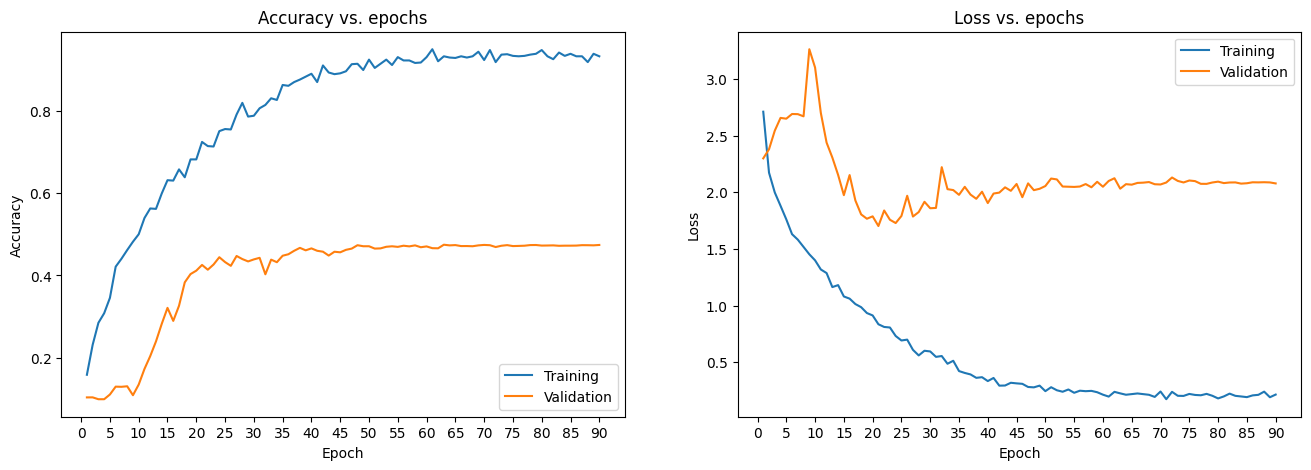

2022-08-16 09:03:51,986: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-16 09:03:56,492: INFO: test loss:2.0314
2022-08-16 09:03:56,493: INFO: test accuracy:0.4746
2022-08-16 09:03:56,495: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-16 09:03:56,496: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-16 09:03:56,496: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator
2022-08-16 09:03:56,498: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator
2022-08-16 09:03:56,498: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/lenet1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:03:57,715: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator


313/313 [==============================] - 1s 2ms/step


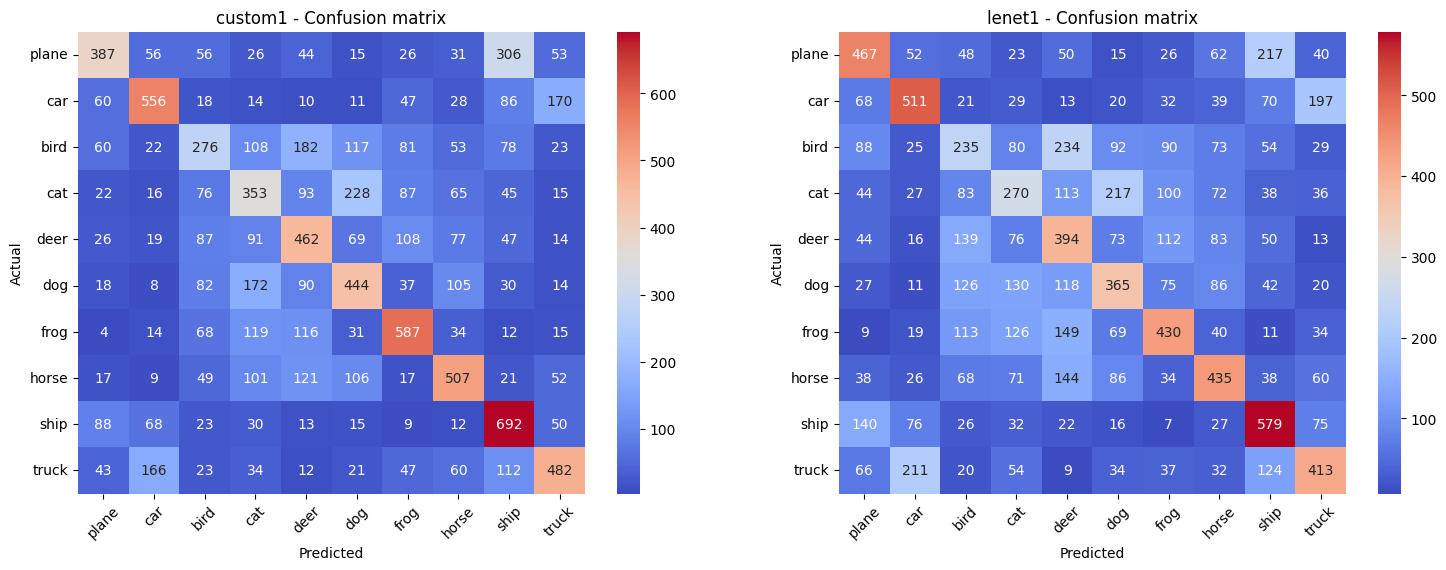

----------------------------------------models----------------------------------------


model_name                program_name  weight_number  train_time  \
1    custom1  cifar10_0816_cnt_100.ipynb          73738       174.0   
2     lenet1  cifar10_0816_cnt_100.ipynb          83170       121.8   
3       mlp1  cifar10_0816_cnt_100.ipynb         394634        76.2   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 09:03      0.0594     2.0314           0.991         0.4746   
2  2022-08-16 09:00      0.1353     2.2138           0.983         0.4099   
3  2022-08-16 08:58      1.0599     1.9446           0.690         0.3416   

   train_auc  test_auc  
1     0.9993    0.8632  
2     0.9988    0.8232  
3     0.9469    0.7775

In [25]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### VGG

In [26]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

tf.Tensor(
[[114  25  33]
 [118  27  36]
 [120  27  37]
 [123  28  39]
 [124  28  39]], shape=(5, 3), dtype=uint8)
tf.Tensor(
[[0.44705886 0.09803922 0.12941177]
 [0.46274513 0.10588236 0.14117648]
 [0.47058827 0.10588236 0.14509805]
 [0.48235297 0.10980393 0.15294118]
 [0.48627454 0.10980393 0.15294118]], shape=(5, 3), dtype=float32)


In [27]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=rescale)
model.summary()


2022-08-16 09:04:01,479: INFO: model_params.vgg8.dropout=0.1
2022-08-16 09:04:01,669: INFO: learning_rate=0.001
2022-08-16 09:04:01,670: INFO: model_params.vgg8.clip_value=None
2022-08-16 09:04:01,676: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                              

2022-08-16 09:04:01,814: INFO: model_params.vgg8.epochs=90
2022-08-16 09:04:01,815: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8, monitor=val_accuracy)
2022-08-16 09:04:01,816: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:04:01,816: INFO: use LearningRateScheduler()
2022-08-16 09:04:01,817: INFO: steps_per_epoch=31
2022-08-16 09:04:01,818: INFO: start training
2022-08-16 09:04:01,818: INFO: use_class_weight=False


Epoch 1/90
30/31 [============================>.] - ETA: 0s - loss: 3.0494 - accuracy: 0.1583

2022-08-16 09:04:08,494: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:04:09,903: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 8s 223ms/step - loss: 3.0239 - accuracy: 0.1573 - val_loss: 2.2525 - val_accuracy: 0.1613 - lr: 0.0010
Epoch 2/90
31/31 [==============================] - 2s 60ms/step - loss: 2.1062 - accuracy: 0.2208 - val_loss: 2.3471 - val_accuracy: 0.1025 - lr: 0.0010
Epoch 3/90
31/31 [==============================] - 3s 97ms/step - loss: 2.0037 - accuracy: 0.2681 - val_loss: 2.4293 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/90
31/31 [==============================] - 2s 64ms/step - loss: 1.8792 - accuracy: 0.3075 - val_loss: 2.4853 - val_accuracy: 0.1004 - lr: 0.0010
Epoch 5/90
31/31 [==============================] - 2s 50ms/step - loss: 1.7934 - accuracy: 0.3427 - val_loss: 2.5017 - val_accuracy: 0.1051 - lr: 0.0010
Epoch 6/90
31/31 [==============================] - 2s 59ms/step - loss: 1.6908 - accuracy: 0.3881 - val_loss: 2.8232 - val_accuracy: 0.1178 - lr: 0.0010
Epoch 7/90
31/31 [==============================] - 3s 95ms/step - loss: 1.5067 - accu

2022-08-16 09:04:32,549: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:04:33,682: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 189ms/step - loss: 1.1595 - accuracy: 0.5847 - val_loss: 2.2332 - val_accuracy: 0.1760 - lr: 0.0010
Epoch 11/90
27/31 [=========================>....] - ETA: 0s - loss: 1.0629 - accuracy: 0.6424

2022-08-16 09:04:37,735: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:04:39,214: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 185ms/step - loss: 1.0467 - accuracy: 0.6522 - val_loss: 2.6148 - val_accuracy: 0.1912 - lr: 0.0010
Epoch 12/90
29/31 [===========================>..] - ETA: 0s - loss: 0.9960 - accuracy: 0.6530

2022-08-16 09:04:43,923: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:04:45,040: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 193ms/step - loss: 1.0062 - accuracy: 0.6522 - val_loss: 2.1295 - val_accuracy: 0.2388 - lr: 0.0010
Epoch 13/90
31/31 [==============================] - 2s 50ms/step - loss: 0.8862 - accuracy: 0.6815 - val_loss: 2.4267 - val_accuracy: 0.2166 - lr: 0.0010
Epoch 14/90
31/31 [==============================] - ETA: 0s - loss: 0.7415 - accuracy: 0.7379

2022-08-16 09:04:51,199: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:04:52,347: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 193ms/step - loss: 0.7415 - accuracy: 0.7379 - val_loss: 2.1966 - val_accuracy: 0.2720 - lr: 0.0010
Epoch 15/90
31/31 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.7500

2022-08-16 09:04:57,095: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:04:58,225: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 194ms/step - loss: 0.7073 - accuracy: 0.7500 - val_loss: 2.2175 - val_accuracy: 0.2974 - lr: 0.0010
Epoch 16/90
31/31 [==============================] - ETA: 0s - loss: 0.6368 - accuracy: 0.7923

2022-08-16 09:05:03,514: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:05:04,634: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 212ms/step - loss: 0.6368 - accuracy: 0.7923 - val_loss: 2.3891 - val_accuracy: 0.3452 - lr: 0.0010
Epoch 17/90
30/31 [============================>.] - ETA: 0s - loss: 0.5731 - accuracy: 0.8042

2022-08-16 09:05:09,988: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:05:11,124: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 215ms/step - loss: 0.5708 - accuracy: 0.8065 - val_loss: 2.5484 - val_accuracy: 0.3649 - lr: 0.0010
Epoch 18/90
30/31 [============================>.] - ETA: 0s - loss: 0.5658 - accuracy: 0.8031

2022-08-16 09:05:16,871: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:05:18,012: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 7s 229ms/step - loss: 0.5851 - accuracy: 0.7974 - val_loss: 2.2480 - val_accuracy: 0.4015 - lr: 0.0010
Epoch 19/90
31/31 [==============================] - 2s 68ms/step - loss: 0.5047 - accuracy: 0.8276 - val_loss: 2.3370 - val_accuracy: 0.3909 - lr: 0.0010
Epoch 20/90
31/31 [==============================] - 2s 80ms/step - loss: 0.4641 - accuracy: 0.8347 - val_loss: 2.5802 - val_accuracy: 0.3752 - lr: 0.0010
Epoch 21/90
31/31 [==============================] - 3s 94ms/step - loss: 0.3429 - accuracy: 0.8851 - val_loss: 2.4233 - val_accuracy: 0.3969 - lr: 0.0010
Epoch 22/90
30/31 [============================>.] - ETA: 0s - loss: 0.2666 - accuracy: 0.9167

2022-08-16 09:05:30,796: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:05:32,176: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 7s 227ms/step - loss: 0.2651 - accuracy: 0.9163 - val_loss: 2.4059 - val_accuracy: 0.4135 - lr: 0.0010
Epoch 23/90
31/31 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.9113

2022-08-16 09:05:37,277: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:05:38,401: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 206ms/step - loss: 0.2735 - accuracy: 0.9113 - val_loss: 2.4086 - val_accuracy: 0.4342 - lr: 0.0010
Epoch 24/90
29/31 [===========================>..] - ETA: 0s - loss: 0.2666 - accuracy: 0.9106

2022-08-16 09:05:43,252: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:05:44,406: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 200ms/step - loss: 0.2693 - accuracy: 0.9083 - val_loss: 2.1231 - val_accuracy: 0.4484 - lr: 0.0010
Epoch 25/90
31/31 [==============================] - 2s 50ms/step - loss: 0.2063 - accuracy: 0.9375 - val_loss: 2.2675 - val_accuracy: 0.4454 - lr: 0.0010
Epoch 26/90
31/31 [==============================] - 2s 66ms/step - loss: 0.1941 - accuracy: 0.9304 - val_loss: 3.0873 - val_accuracy: 0.3745 - lr: 0.0010
Epoch 27/90
31/31 [==============================] - 2s 79ms/step - loss: 0.1818 - accuracy: 0.9375 - val_loss: 2.7109 - val_accuracy: 0.4123 - lr: 0.0010
Epoch 28/90
31/31 [==============================] - 2s 72ms/step - loss: 0.1991 - accuracy: 0.9335 - val_loss: 2.8756 - val_accuracy: 0.4210 - lr: 0.0010
Epoch 29/90
31/31 [==============================] - 3s 93ms/step - loss: 0.1920 - accuracy: 0.9405 - val_loss: 2.8826 - val_accuracy: 0.4110 - lr: 0.0010
Epoch 30/90
31/31 [==============================] - 3s 94ms/step - loss: 0.1430 

2022-08-16 09:06:02,871: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:06:04,072: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 194ms/step - loss: 0.1565 - accuracy: 0.9496 - val_loss: 2.6023 - val_accuracy: 0.4606 - lr: 0.0010
Epoch 32/90
31/31 [==============================] - 2s 72ms/step - loss: 0.1692 - accuracy: 0.9355 - val_loss: 2.9372 - val_accuracy: 0.4202 - lr: 0.0010
Epoch 33/90
31/31 [==============================] - 2s 50ms/step - loss: 0.1576 - accuracy: 0.9395 - val_loss: 2.8778 - val_accuracy: 0.3909 - lr: 0.0010
Epoch 34/90
31/31 [==============================] - 2s 70ms/step - loss: 0.1855 - accuracy: 0.9345 - val_loss: 2.7630 - val_accuracy: 0.4238 - lr: 0.0010
Epoch 35/90
31/31 [==============================] - 2s 73ms/step - loss: 0.1656 - accuracy: 0.9435 - val_loss: 2.9293 - val_accuracy: 0.4384 - lr: 0.0010
Epoch 36/90
31/31 [==============================] - 2s 73ms/step - loss: 0.2052 - accuracy: 0.9294 - val_loss: 2.4126 - val_accuracy: 0.4568 - lr: 0.0010
Epoch 37/90
31/31 [==============================] - 3s 96ms/step - loss: 0.1465 

2022-08-16 09:06:25,283: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:06:26,399: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets



Epoch 39: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
31/31 [==============================] - 6s 207ms/step - loss: 0.1163 - accuracy: 0.9637 - val_loss: 2.5156 - val_accuracy: 0.4743 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/90
31/31 [==============================] - 3s 89ms/step - loss: 0.0799 - accuracy: 0.9738 - val_loss: 2.6868 - val_accuracy: 0.4646 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/90
31/31 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.9738

2022-08-16 09:06:33,644: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:06:34,791: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 189ms/step - loss: 0.0786 - accuracy: 0.9738 - val_loss: 2.4461 - val_accuracy: 0.4952 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/90
31/31 [==============================] - 3s 95ms/step - loss: 0.0563 - accuracy: 0.9798 - val_loss: 2.4816 - val_accuracy: 0.4835 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/90
31/31 [==============================] - 2s 81ms/step - loss: 0.0645 - accuracy: 0.9778 - val_loss: 2.4521 - val_accuracy: 0.4952 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/90
29/31 [===========================>..] - ETA: 0s - loss: 0.0526 - accuracy: 0.9806

2022-08-16 09:06:44,963: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:06:46,106: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 200ms/step - loss: 0.0550 - accuracy: 0.9788 - val_loss: 2.4529 - val_accuracy: 0.4993 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/90
31/31 [==============================] - 2s 65ms/step - loss: 0.0465 - accuracy: 0.9859 - val_loss: 2.4388 - val_accuracy: 0.4987 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/90
31/31 [==============================] - 2s 50ms/step - loss: 0.0564 - accuracy: 0.9859 - val_loss: 2.4616 - val_accuracy: 0.4992 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/90
31/31 [==============================] - 2s 71ms/step - loss: 0.0404 - accuracy: 0.9859 - val_loss: 2.5085 - val_accuracy: 0.4944 - lr: 3.1623e-04
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
Epoch 48/90
31/31 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9849

2022-08-16 09:06:57,244: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:06:58,698: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 7s 231ms/step - loss: 0.0438 - accuracy: 0.9849 - val_loss: 2.4318 - val_accuracy: 0.4998 - lr: 3.1623e-04
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
Epoch 49/90
30/31 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9885

2022-08-16 09:07:04,012: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:07:05,131: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 213ms/step - loss: 0.0357 - accuracy: 0.9889 - val_loss: 2.4292 - val_accuracy: 0.5005 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/90
31/31 [==============================] - 3s 93ms/step - loss: 0.0372 - accuracy: 0.9859 - val_loss: 2.4776 - val_accuracy: 0.4980 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/90
31/31 [==============================] - 3s 96ms/step - loss: 0.0458 - accuracy: 0.9798 - val_loss: 2.4213 - val_accuracy: 0.4962 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/90
31/31 [==============================] - 3s 98ms/step - loss: 0.0328 - accuracy: 0.9869 - val_loss: 2.6024 - val_accuracy: 0.4879 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/90
31/31 [==============================] - 3s 95ms/step - loss: 0.0384 - accuracy: 0.9889 - val_loss: 2.5

2022-08-16 09:07:27,675: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:07:29,199: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 7s 226ms/step - loss: 0.0343 - accuracy: 0.9889 - val_loss: 2.5016 - val_accuracy: 0.5021 - lr: 1.0000e-04
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
Epoch 57/90
31/31 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9869

2022-08-16 09:07:34,496: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:07:35,698: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 214ms/step - loss: 0.0390 - accuracy: 0.9869 - val_loss: 2.5394 - val_accuracy: 0.5041 - lr: 1.0000e-04
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
Epoch 58/90
31/31 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9929

2022-08-16 09:07:41,501: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:07:42,643: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 7s 230ms/step - loss: 0.0311 - accuracy: 0.9929 - val_loss: 2.5285 - val_accuracy: 0.5051 - lr: 1.0000e-04
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
Epoch 59/90
31/31 [==============================] - 2s 72ms/step - loss: 0.0316 - accuracy: 0.9869 - val_loss: 2.5161 - val_accuracy: 0.5043 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/90
31/31 [==============================] - 2s 77ms/step - loss: 0.0392 - accuracy: 0.9869 - val_loss: 2.5078 - val_accuracy: 0.5040 - lr: 1.0000e-04
Epoch 61/90
31/31 [==============================] - 3s 92ms/step - loss: 0.0372 - accuracy: 0.9839 - val_loss: 2.5126 - val_accuracy: 0.5025 - lr: 1.0000e-04
Epoch 62/90
31/31 [==============================] - 2s 68ms/step - loss: 0.0315 - accuracy: 0.9889 - val_loss: 2.5187 - val_accuracy: 0.5023 - lr: 1.0000e-04
Epoch 63/90
31/31 [==============================] - 2s 81ms/step - loss: 0.0399 - accuracy:

2022-08-16 09:08:04,117: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:08:05,266: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 196ms/step - loss: 0.0301 - accuracy: 0.9899 - val_loss: 2.5287 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 67/90
31/31 [==============================] - 3s 90ms/step - loss: 0.0246 - accuracy: 0.9909 - val_loss: 2.5460 - val_accuracy: 0.5040 - lr: 1.0000e-04
Epoch 68/90
31/31 [==============================] - 3s 83ms/step - loss: 0.0211 - accuracy: 0.9909 - val_loss: 2.5654 - val_accuracy: 0.5022 - lr: 1.0000e-04
Epoch 69/90
31/31 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9929
Epoch 69: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
31/31 [==============================] - 2s 50ms/step - loss: 0.0291 - accuracy: 0.9929 - val_loss: 2.6045 - val_accuracy: 0.5026 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/90
31/31 [==============================] - 2s 51ms/step - loss: 0.0264 - accuracy: 0.9919 - val_loss: 2.5980 - val_accuracy: 0.5032 - lr: 3

2022-08-16 09:08:29,272: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:08:30,421: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 6s 215ms/step - loss: 0.0316 - accuracy: 0.9899 - val_loss: 2.5881 - val_accuracy: 0.5060 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/90
31/31 [==============================] - 3s 97ms/step - loss: 0.0296 - accuracy: 0.9899 - val_loss: 2.5929 - val_accuracy: 0.5057 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/90
31/31 [==============================] - 3s 92ms/step - loss: 0.0252 - accuracy: 0.9929 - val_loss: 2.5934 - val_accuracy: 0.5043 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/90
31/31 [==============================] - 2s 82ms/step - loss: 0.0261 - accuracy: 0.9909 - val_loss: 2.5939 - val_accuracy: 0.5044 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/90
31/31 [==============================] - 2s 68ms/step - loss: 0.0270 - accuracy: 0.9919 - val_loss: 2.5

2022-08-16 09:09:01,092: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:09:02,226: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets



Epoch 84: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
31/31 [==============================] - 8s 277ms/step - loss: 0.0261 - accuracy: 0.9919 - val_loss: 2.5895 - val_accuracy: 0.5065 - lr: 1.0000e-05
Epoch 00085: Still keep learning rate 1e-05 instead of 0.0001
Epoch 85/90
31/31 [==============================] - 5s 158ms/step - loss: 0.0255 - accuracy: 0.9929 - val_loss: 2.5922 - val_accuracy: 0.5064 - lr: 1.0000e-05
Epoch 00086: Still keep learning rate 1e-05 instead of 0.0001
Epoch 86/90
30/31 [============================>.] - ETA: 0s - loss: 0.0349 - accuracy: 0.9844

2022-08-16 09:09:14,631: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:09:15,781: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 9s 290ms/step - loss: 0.0356 - accuracy: 0.9849 - val_loss: 2.5889 - val_accuracy: 0.5070 - lr: 1.0000e-05
Epoch 00087: Still keep learning rate 1e-05 instead of 0.0001
Epoch 87/90
30/31 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9865

2022-08-16 09:09:21,033: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


2022-08-16 09:09:22,477: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8/assets


31/31 [==============================] - 7s 223ms/step - loss: 0.0309 - accuracy: 0.9869 - val_loss: 2.5938 - val_accuracy: 0.5071 - lr: 1.0000e-05
Epoch 00088: Still keep learning rate 1e-05 instead of 0.0001
Epoch 88/90
31/31 [==============================] - 3s 93ms/step - loss: 0.0250 - accuracy: 0.9929 - val_loss: 2.5919 - val_accuracy: 0.5059 - lr: 1.0000e-05
Epoch 00089: Still keep learning rate 1e-05 instead of 0.0001
Epoch 89/90
31/31 [==============================] - 3s 93ms/step - loss: 0.0250 - accuracy: 0.9889 - val_loss: 2.5934 - val_accuracy: 0.5061 - lr: 1.0000e-05
Epoch 00090: Still keep learning rate 1e-05 instead of 0.0001
Epoch 90/90
31/31 [==============================] - 3s 100ms/step - loss: 0.0256 - accuracy: 0.9919 - val_loss: 2.5996 - val_accuracy: 0.5050 - lr: 1.0000e-05


2022-08-16 09:09:31,296: INFO: finish training [elapsed time: 329.48 seconds]


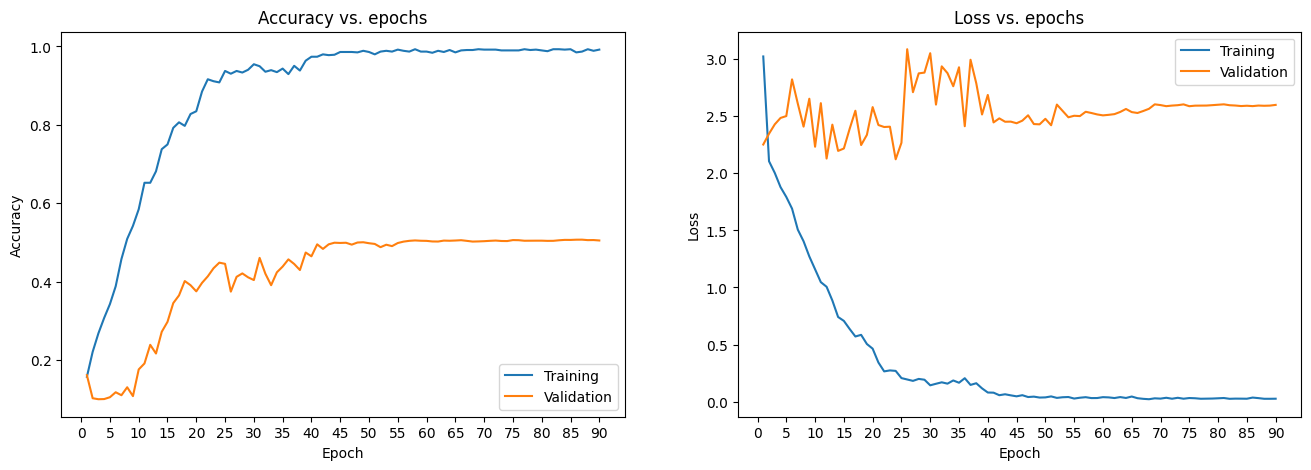

2022-08-16 09:09:31,722: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 5ms/step


2022-08-16 09:09:38,338: INFO: test loss:2.5938
2022-08-16 09:09:38,339: INFO: test accuracy:0.5071
2022-08-16 09:09:38,341: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-16 09:09:38,343: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-16 09:09:38,344: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator
2022-08-16 09:09:38,345: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator
2022-08-16 09:09:38,346: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/custom1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:09:39,535: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator


313/313 [==============================] - 1s 4ms/step


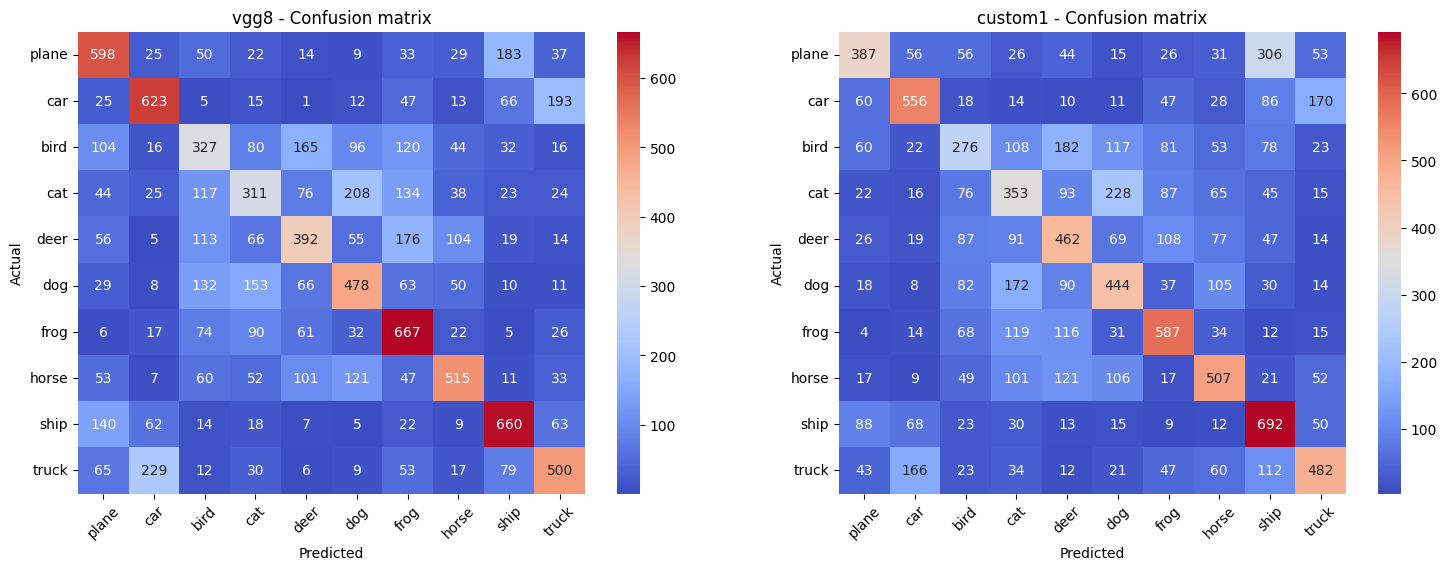

----------------------------------------models----------------------------------------


model_name                program_name  weight_number  train_time  \
1       vgg8  cifar10_0816_cnt_100.ipynb        1672906       329.5   
2    custom1  cifar10_0816_cnt_100.ipynb          73738       174.0   
3     lenet1  cifar10_0816_cnt_100.ipynb          83170       121.8   
4       mlp1  cifar10_0816_cnt_100.ipynb         394634        76.2   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 09:09      0.0096     2.5938           0.996         0.5071   
2  2022-08-16 09:03      0.0594     2.0314           0.991         0.4746   
3  2022-08-16 09:00      0.1353     2.2138           0.983         0.4099   
4  2022-08-16 08:58      1.0599     1.9446           0.690         0.3416   

   train_auc  test_auc  
1     1.0000    0.8761  
2     0.9993    0.8632  
3     0.9988    0.8232  
4     0.9469    0.7775

In [28]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2022-08-16 09:09:45,696: INFO: learning_rate=0.001
2022-08-16 09:09:45,697: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-16 09:09:45,704: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['rescaling[4][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                          

                                                                                                  
 conv2d_15 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_nor

 add_8 (Add)                    (None, 8, 8, 64)     0           ['activation_16[0][0]',          
                                                                  'batch_normalization_23[0][0]'] 
                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (

2022-08-16 09:09:45,830: INFO: model_params.resnet_v1_20.epochs=90
2022-08-16 09:09:45,831: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20, monitor=val_accuracy)
2022-08-16 09:09:45,832: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:09:45,832: INFO: use LearningRateScheduler()
2022-08-16 09:09:45,833: INFO: steps_per_epoch=31
2022-08-16 09:09:45,833: INFO: start training
2022-08-16 09:09:45,834: INFO: use_class_weight=False


Epoch 1/90
31/31 [==============================] - ETA: 0s - loss: 2.3971 - accuracy: 0.2127

2022-08-16 09:10:05,112: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:10:08,284: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 23s 611ms/step - loss: 2.3971 - accuracy: 0.2127 - val_loss: 2.6139 - val_accuracy: 0.1304 - lr: 0.0010
Epoch 2/90
31/31 [==============================] - ETA: 0s - loss: 1.8117 - accuracy: 0.3942

2022-08-16 09:10:19,738: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:10:23,071: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 15s 493ms/step - loss: 1.8117 - accuracy: 0.3942 - val_loss: 2.3108 - val_accuracy: 0.2033 - lr: 0.0010
Epoch 3/90
31/31 [==============================] - 4s 135ms/step - loss: 1.4679 - accuracy: 0.5665 - val_loss: 2.9406 - val_accuracy: 0.1275 - lr: 0.0010
Epoch 4/90
31/31 [==============================] - 6s 210ms/step - loss: 1.0884 - accuracy: 0.7298 - val_loss: 3.5931 - val_accuracy: 0.1589 - lr: 0.0010
Epoch 5/90
31/31 [==============================] - 6s 196ms/step - loss: 0.7847 - accuracy: 0.8327 - val_loss: 4.7772 - val_accuracy: 0.1873 - lr: 0.0010
Epoch 6/90
31/31 [==============================] - 5s 173ms/step - loss: 0.8199 - accuracy: 0.7853 - val_loss: 4.7094 - val_accuracy: 0.1904 - lr: 0.0010
Epoch 7/90
31/31 [==============================] - 5s 178ms/step - loss: 0.8323 - accuracy: 0.7792 - val_loss: 6.6079 - val_accuracy: 0.1442 - lr: 0.0010
Epoch 8/90
31/31 [==============================] - 3s 95ms/step - loss: 0.5520 

2022-08-16 09:11:07,745: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:11:11,409: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 15s 489ms/step - loss: 0.2665 - accuracy: 0.9778 - val_loss: 4.7477 - val_accuracy: 0.2323 - lr: 0.0010
Epoch 11/90
31/31 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9960

2022-08-16 09:11:21,333: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:11:24,388: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 13s 432ms/step - loss: 0.2133 - accuracy: 0.9960 - val_loss: 3.1774 - val_accuracy: 0.2870 - lr: 0.0010
Epoch 12/90
31/31 [==============================] - 5s 175ms/step - loss: 0.1968 - accuracy: 0.9950 - val_loss: 3.5446 - val_accuracy: 0.2562 - lr: 0.0010
Epoch 13/90
29/31 [===========================>..] - ETA: 0s - loss: 0.1771 - accuracy: 1.0000

2022-08-16 09:11:40,124: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:11:43,460: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 14s 456ms/step - loss: 0.1766 - accuracy: 1.0000 - val_loss: 3.2170 - val_accuracy: 0.3131 - lr: 0.0010
Epoch 14/90
31/31 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 1.0000

2022-08-16 09:11:53,719: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:11:57,438: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 14s 466ms/step - loss: 0.1657 - accuracy: 1.0000 - val_loss: 3.0580 - val_accuracy: 0.3146 - lr: 0.0010
Epoch 15/90
31/31 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 1.0000

2022-08-16 09:12:10,065: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:12:13,348: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 16s 530ms/step - loss: 0.1635 - accuracy: 1.0000 - val_loss: 2.9137 - val_accuracy: 0.3283 - lr: 0.0010
Epoch 16/90
29/31 [===========================>..] - ETA: 0s - loss: 0.1623 - accuracy: 1.0000

2022-08-16 09:12:23,813: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:12:26,942: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 14s 451ms/step - loss: 0.1623 - accuracy: 1.0000 - val_loss: 2.8291 - val_accuracy: 0.3373 - lr: 0.0010
Epoch 17/90
31/31 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 1.0000

2022-08-16 09:12:38,083: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:12:41,123: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
31/31 [==============================] - 14s 468ms/step - loss: 0.1613 - accuracy: 1.0000 - val_loss: 2.7826 - val_accuracy: 0.3475 - lr: 3.1623e-04
Epoch 00018: Still keep learning rate 0.0003162 instead of 0.001
Epoch 18/90
31/31 [==============================] - ETA: 0s - loss: 0.1607 - accuracy: 1.0000

2022-08-16 09:12:53,637: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:12:56,982: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 16s 526ms/step - loss: 0.1607 - accuracy: 1.0000 - val_loss: 2.7433 - val_accuracy: 0.3497 - lr: 3.1623e-04
Epoch 00019: Still keep learning rate 0.0003162 instead of 0.001
Epoch 19/90
31/31 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 1.0000

2022-08-16 09:13:07,622: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:13:10,814: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 14s 460ms/step - loss: 0.1604 - accuracy: 1.0000 - val_loss: 2.7210 - val_accuracy: 0.3531 - lr: 3.1623e-04
Epoch 00020: Still keep learning rate 0.0003162 instead of 0.001
Epoch 20/90
31/31 [==============================] - ETA: 0s - loss: 0.1601 - accuracy: 1.0000

2022-08-16 09:13:21,296: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:13:24,379: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 14s 451ms/step - loss: 0.1601 - accuracy: 1.0000 - val_loss: 2.7082 - val_accuracy: 0.3551 - lr: 3.1623e-04
Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/90
31/31 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 1.0000

2022-08-16 09:13:37,255: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:13:40,585: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 16s 537ms/step - loss: 0.1599 - accuracy: 1.0000 - val_loss: 2.7014 - val_accuracy: 0.3553 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/90
31/31 [==============================] - 3s 93ms/step - loss: 0.1596 - accuracy: 1.0000 - val_loss: 2.6981 - val_accuracy: 0.3544 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/90
31/31 [==============================] - 3s 86ms/step - loss: 0.1593 - accuracy: 1.0000 - val_loss: 2.6968 - val_accuracy: 0.3546 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/90
31/31 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 1.0000

2022-08-16 09:13:56,381: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:13:59,630: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 14s 454ms/step - loss: 0.1590 - accuracy: 1.0000 - val_loss: 2.6969 - val_accuracy: 0.3565 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/90
31/31 [==============================] - 4s 127ms/step - loss: 0.1587 - accuracy: 1.0000 - val_loss: 2.6978 - val_accuracy: 0.3564 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/90
31/31 [==============================] - 4s 141ms/step - loss: 0.1584 - accuracy: 1.0000 - val_loss: 2.6994 - val_accuracy: 0.3564 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/90
31/31 [==============================] - 5s 159ms/step - loss: 0.1581 - accuracy: 1.0000 - val_loss: 2.7013 - val_accuracy: 0.3564 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
31/31 [==============================] - 3s 104ms/step - loss: 0.1578 - accuracy: 1.0000 - val_loss

2022-08-16 09:14:25,829: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:14:28,939: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 13s 437ms/step - loss: 0.1575 - accuracy: 1.0000 - val_loss: 2.7060 - val_accuracy: 0.3568 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/90
31/31 [==============================] - 3s 113ms/step - loss: 0.1572 - accuracy: 1.0000 - val_loss: 2.7085 - val_accuracy: 0.3568 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/90
31/31 [==============================] - 3s 105ms/step - loss: 0.1569 - accuracy: 1.0000 - val_loss: 2.7111 - val_accuracy: 0.3563 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
31/31 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 1.0000
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
31/31 [==============================] - 3s 104ms/step - loss: 0.1566 - accuracy: 1.0000 - val_loss: 2.7138 - val_accuracy: 0.3564 - lr: 1.0000e-04
Epoch 00033: St

2022-08-16 09:14:55,660: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:14:59,085: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 15s 508ms/step - loss: 0.1562 - accuracy: 1.0000 - val_loss: 2.7164 - val_accuracy: 0.3573 - lr: 1.0000e-04
Epoch 00035: Still keep learning rate 0.0001 instead of 0.001
Epoch 35/90
31/31 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 1.0000

2022-08-16 09:15:09,348: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


2022-08-16 09:15:12,479: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20/assets


31/31 [==============================] - 13s 446ms/step - loss: 0.1561 - accuracy: 1.0000 - val_loss: 2.7177 - val_accuracy: 0.3576 - lr: 1.0000e-04
Epoch 00036: Still keep learning rate 0.0001 instead of 0.001
Epoch 36/90
31/31 [==============================] - 3s 99ms/step - loss: 0.1560 - accuracy: 1.0000 - val_loss: 2.7189 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 00037: Still keep learning rate 0.0001 instead of 0.001
Epoch 37/90
31/31 [==============================] - 3s 115ms/step - loss: 0.1559 - accuracy: 1.0000 - val_loss: 2.7201 - val_accuracy: 0.3570 - lr: 1.0000e-04
Epoch 00038: Still keep learning rate 0.0001 instead of 0.001
Epoch 38/90
31/31 [==============================] - 5s 159ms/step - loss: 0.1558 - accuracy: 1.0000 - val_loss: 2.7213 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 00039: Still keep learning rate 0.0001 instead of 0.001
Epoch 39/90
31/31 [==============================] - 4s 136ms/step - loss: 0.1557 - accuracy: 1.0000 - val_loss: 2.7225 - va

31/31 [==============================] - 3s 104ms/step - loss: 0.1374 - accuracy: 1.0000 - val_loss: 2.8526 - val_accuracy: 0.3526 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/90
31/31 [==============================] - 3s 106ms/step - loss: 0.1374 - accuracy: 1.0000 - val_loss: 2.8531 - val_accuracy: 0.3527 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/90
31/31 [==============================] - 3s 104ms/step - loss: 0.1373 - accuracy: 1.0000 - val_loss: 2.8535 - val_accuracy: 0.3528 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/90
30/31 [============================>.] - ETA: 0s - loss: 0.1373 - accuracy: 1.0000
Epoch 77: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
31/31 [==============================] - 3s 108ms/step - loss: 0.1373 - accuracy: 1.0000 - val_loss: 2.8538 - val_accuracy: 0.3527 - lr: 1.0000e-05
Epoch 00078: Stil

2022-08-16 09:18:36,524: INFO: finish training [elapsed time: 530.69 seconds]


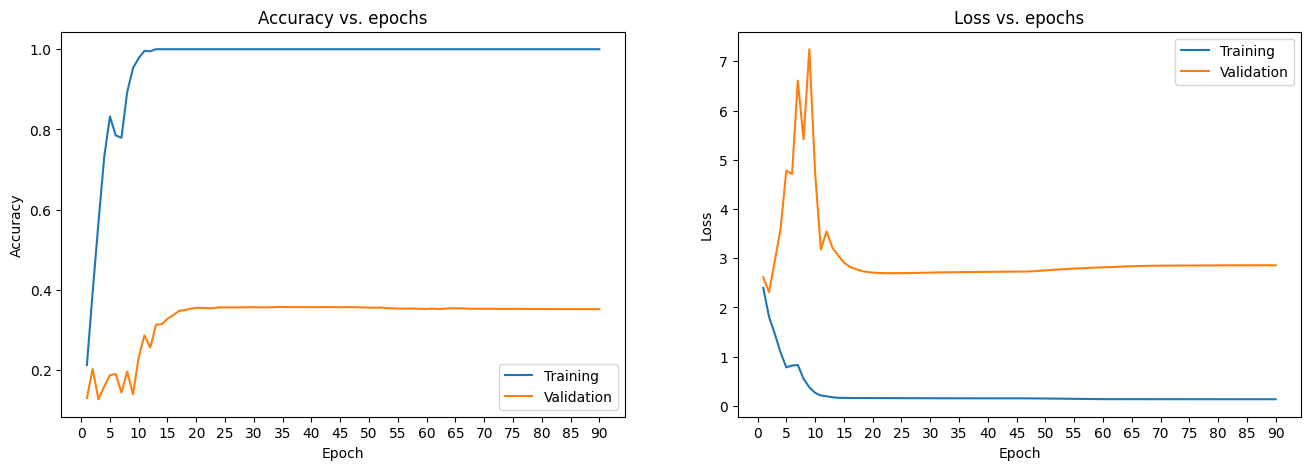

2022-08-16 09:18:36,955: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 7ms/step


2022-08-16 09:18:50,411: INFO: test loss:2.7177
2022-08-16 09:18:50,412: INFO: test accuracy:0.3576
2022-08-16 09:18:50,416: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-16 09:18:50,417: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-16 09:18:50,418: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator
2022-08-16 09:18:50,419: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator
2022-08-16 09:18:50,420: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:18:52,281: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator


313/313 [==============================] - 2s 5ms/step


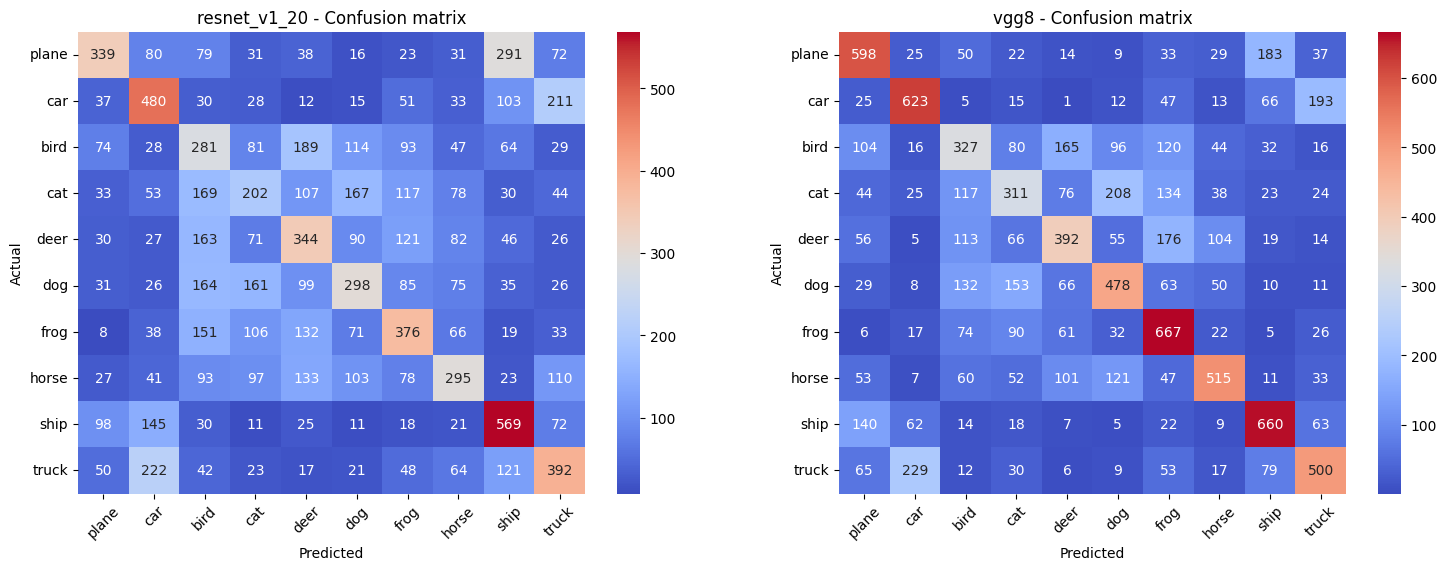

----------------------------------------models----------------------------------------


model_name                program_name  weight_number  train_time  \
1          vgg8  cifar10_0816_cnt_100.ipynb        1672906       329.5   
2       custom1  cifar10_0816_cnt_100.ipynb          73738       174.0   
3        lenet1  cifar10_0816_cnt_100.ipynb          83170       121.8   
4  resnet_v1_20  cifar10_0816_cnt_100.ipynb         273066       530.7   
5          mlp1  cifar10_0816_cnt_100.ipynb         394634        76.2   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 09:09      0.0096     2.5938           0.996         0.5071   
2  2022-08-16 09:03      0.0594     2.0314           0.991         0.4746   
3  2022-08-16 09:00      0.1353     2.2138           0.983         0.4099   
4  2022-08-16 09:18      0.1851     2.7177           0.993         0.3576   
5  2022-08-16 08:58      1.0599     1.9446           0.690         0.3416   

   train_auc  test_auc  
1     1.0000    0.8761  
2     0.9993    0.8632  
3     0.9988    0.8232  
4     0.9999    0.7880  
5     0.9469    0.7775

In [29]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [23]:
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ResizeLayer, self).__init__()
        self.shape = shape

    def call(self, inputs, training=False):
#         print(type(inputs))
#         return tf.convert_to_tensor(resize_images(inputs.numpy(), self.shape))
        return tf.image.resize(inputs, self.shape)

In [24]:
rescale1 = tf.keras.layers.Rescaling(1./127.5, offset=-1)
input_shape = [160, 160, 3]

In [25]:
preprocess_fun =  [ResizeLayer(input_shape[:-1]), rescale1]

(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


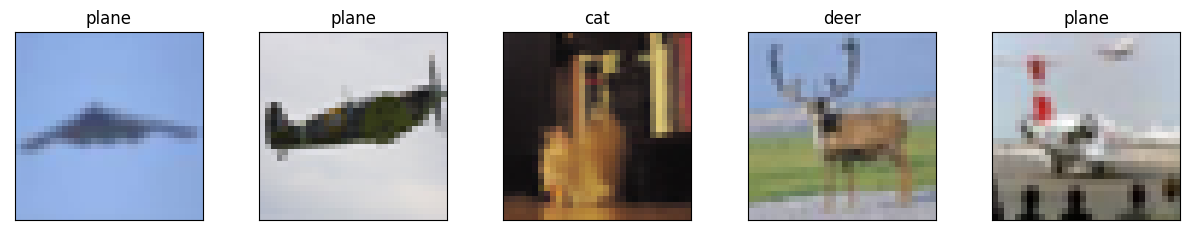

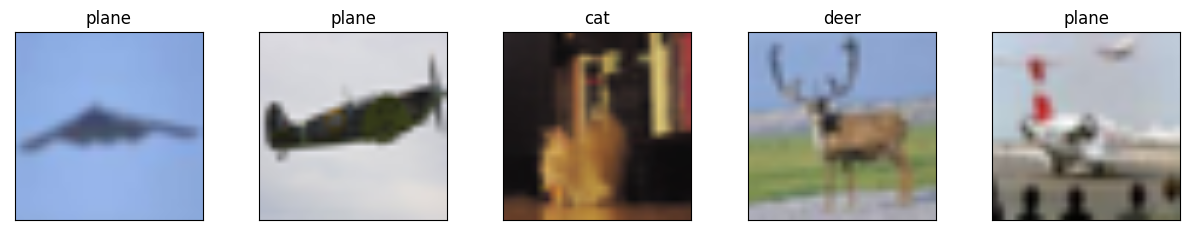

In [26]:
sample_images1 = ResizeLayer(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))

#### MobileNet V2

In [27]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [28]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [29]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-08-18 20:00:27,527: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-08-18 20:00:27,528: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-18 20:00:27,539: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resize_layer (ResizeLayer)  (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (D

2022-08-18 20:00:37,287: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-18 20:00:37,288: INFO: steps_per_epoch=31
2022-08-18 20:00:37,289: INFO: start training
2022-08-18 20:00:37,289: INFO: use_class_weight=False


Epoch 1/10
31/31 [==============================] - ETA: 0s - loss: 2.7372 - accuracy: 0.1351

2022-08-18 20:01:03,034: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:01:07,928: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 31s 952ms/step - loss: 2.7372 - accuracy: 0.1351 - val_loss: 2.3917 - val_accuracy: 0.1752
Epoch 2/10
31/31 [==============================] - ETA: 0s - loss: 2.3910 - accuracy: 0.1986

2022-08-18 20:01:32,765: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:01:37,646: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 30s 989ms/step - loss: 2.3910 - accuracy: 0.1986 - val_loss: 2.1384 - val_accuracy: 0.2501
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 2.0980 - accuracy: 0.2883

2022-08-18 20:02:03,299: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:02:07,867: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 30s 1s/step - loss: 2.0980 - accuracy: 0.2883 - val_loss: 1.9347 - val_accuracy: 0.3257
Epoch 4/10
31/31 [==============================] - ETA: 0s - loss: 1.9487 - accuracy: 0.3488

2022-08-18 20:02:34,596: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:02:39,424: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 32s 1s/step - loss: 1.9487 - accuracy: 0.3488 - val_loss: 1.7608 - val_accuracy: 0.3960
Epoch 5/10
31/31 [==============================] - ETA: 0s - loss: 1.7391 - accuracy: 0.3931

2022-08-18 20:03:06,874: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:03:11,368: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 32s 1s/step - loss: 1.7391 - accuracy: 0.3931 - val_loss: 1.6171 - val_accuracy: 0.4551
Epoch 6/10
31/31 [==============================] - ETA: 0s - loss: 1.6126 - accuracy: 0.4435

2022-08-18 20:03:40,218: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:03:44,781: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 33s 1s/step - loss: 1.6126 - accuracy: 0.4435 - val_loss: 1.4946 - val_accuracy: 0.5035
Epoch 7/10
31/31 [==============================] - ETA: 0s - loss: 1.4502 - accuracy: 0.5111

2022-08-18 20:04:14,033: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:04:18,517: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 34s 1s/step - loss: 1.4502 - accuracy: 0.5111 - val_loss: 1.3918 - val_accuracy: 0.5456
Epoch 8/10
31/31 [==============================] - ETA: 0s - loss: 1.3647 - accuracy: 0.5423

2022-08-18 20:04:48,649: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:04:53,372: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 35s 1s/step - loss: 1.3647 - accuracy: 0.5423 - val_loss: 1.3036 - val_accuracy: 0.5770
Epoch 9/10
31/31 [==============================] - ETA: 0s - loss: 1.2568 - accuracy: 0.5716

2022-08-18 20:05:23,484: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:05:28,006: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 35s 1s/step - loss: 1.2568 - accuracy: 0.5716 - val_loss: 1.2286 - val_accuracy: 0.6065
Epoch 10/10
31/31 [==============================] - ETA: 0s - loss: 1.1591 - accuracy: 0.6240

2022-08-18 20:05:57,667: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:06:02,148: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 34s 1s/step - loss: 1.1591 - accuracy: 0.6240 - val_loss: 1.1663 - val_accuracy: 0.6295


2022-08-18 20:06:02,850: INFO: finish training [elapsed time: 325.56 seconds]


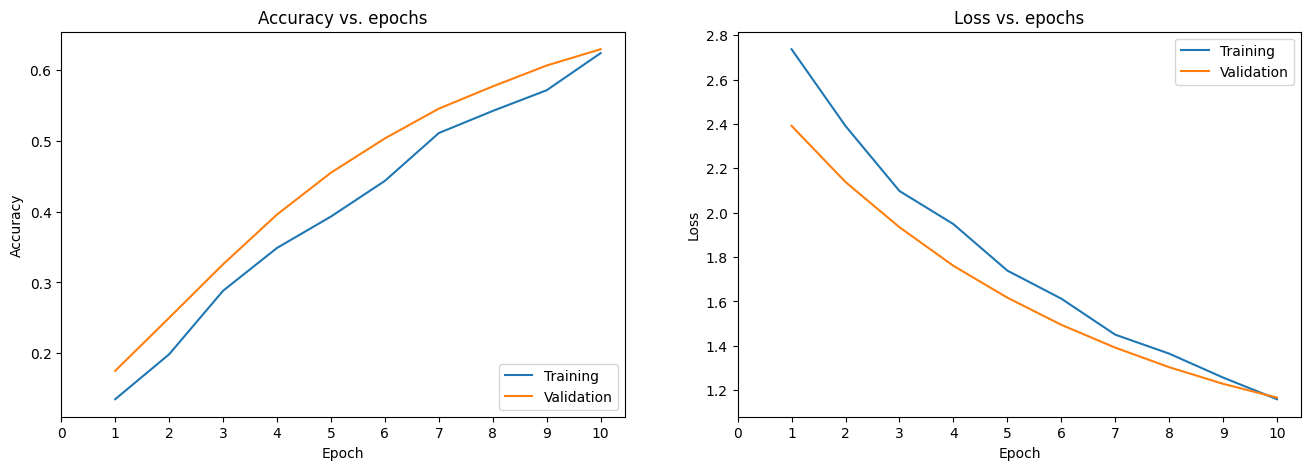

In [30]:
history = helper.train(model, epochs=10, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))

In [31]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-08-18 20:06:03,363: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-18 20:06:03,364: INFO: steps_per_epoch=31
2022-08-18 20:06:03,364: INFO: start training
2022-08-18 20:06:03,365: INFO: use_class_weight=False


Epoch 1/15
31/31 [==============================] - ETA: 0s - loss: 0.9692 - accuracy: 0.6784

2022-08-18 20:06:36,296: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:06:41,132: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 38s 1s/step - loss: 0.9692 - accuracy: 0.6784 - val_loss: 0.8715 - val_accuracy: 0.7084
Epoch 2/15
31/31 [==============================] - ETA: 0s - loss: 0.7383 - accuracy: 0.7399

2022-08-18 20:07:10,962: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:07:15,698: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 35s 1s/step - loss: 0.7383 - accuracy: 0.7399 - val_loss: 0.7796 - val_accuracy: 0.7354
Epoch 3/15
31/31 [==============================] - ETA: 0s - loss: 0.5624 - accuracy: 0.8216

2022-08-18 20:07:43,752: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:07:48,447: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 33s 1s/step - loss: 0.5624 - accuracy: 0.8216 - val_loss: 0.7181 - val_accuracy: 0.7573
Epoch 4/15
31/31 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.8427

2022-08-18 20:08:15,116: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:08:19,847: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 31s 1s/step - loss: 0.4792 - accuracy: 0.8427 - val_loss: 0.6780 - val_accuracy: 0.7685
Epoch 5/15
31/31 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.8770

2022-08-18 20:08:45,393: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:08:50,169: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 30s 1s/step - loss: 0.3959 - accuracy: 0.8770 - val_loss: 0.6633 - val_accuracy: 0.7737
Epoch 6/15
31/31 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.8982

2022-08-18 20:09:14,771: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:09:19,826: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 30s 987ms/step - loss: 0.3073 - accuracy: 0.8982 - val_loss: 0.6365 - val_accuracy: 0.7846
Epoch 7/15
31/31 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.9234

2022-08-18 20:09:44,894: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:09:49,709: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 30s 996ms/step - loss: 0.2687 - accuracy: 0.9234 - val_loss: 0.6291 - val_accuracy: 0.7898
Epoch 8/15
31/31 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9365

2022-08-18 20:10:14,391: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:10:19,546: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 30s 991ms/step - loss: 0.2252 - accuracy: 0.9365 - val_loss: 0.6152 - val_accuracy: 0.7934
Epoch 9/15
31/31 [==============================] - ETA: 0s - loss: 0.1906 - accuracy: 0.9476

2022-08-18 20:10:43,943: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:10:48,760: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 29s 972ms/step - loss: 0.1906 - accuracy: 0.9476 - val_loss: 0.6113 - val_accuracy: 0.7977
Epoch 10/15
31/31 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9637

2022-08-18 20:11:17,190: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:11:22,036: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 33s 1s/step - loss: 0.1417 - accuracy: 0.9637 - val_loss: 0.5972 - val_accuracy: 0.8041
Epoch 11/15
31/31 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9748

2022-08-18 20:11:53,438: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:11:58,155: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 36s 1s/step - loss: 0.1238 - accuracy: 0.9748 - val_loss: 0.6020 - val_accuracy: 0.8062
Epoch 12/15
31/31 [==============================] - 8s 256ms/step - loss: 0.1099 - accuracy: 0.9758 - val_loss: 0.6153 - val_accuracy: 0.8032
Epoch 13/15
31/31 [==============================] - 14s 479ms/step - loss: 0.0854 - accuracy: 0.9889 - val_loss: 0.6118 - val_accuracy: 0.8050
Epoch 14/15
31/31 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9879

2022-08-18 20:12:51,933: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


2022-08-18 20:12:56,687: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2/assets


31/31 [==============================] - 36s 1s/step - loss: 0.0810 - accuracy: 0.9879 - val_loss: 0.6070 - val_accuracy: 0.8102
Epoch 15/15
31/31 [==============================] - 8s 252ms/step - loss: 0.0689 - accuracy: 0.9869 - val_loss: 0.6160 - val_accuracy: 0.8091


2022-08-18 20:13:05,017: INFO: finish training [elapsed time: 421.65 seconds]


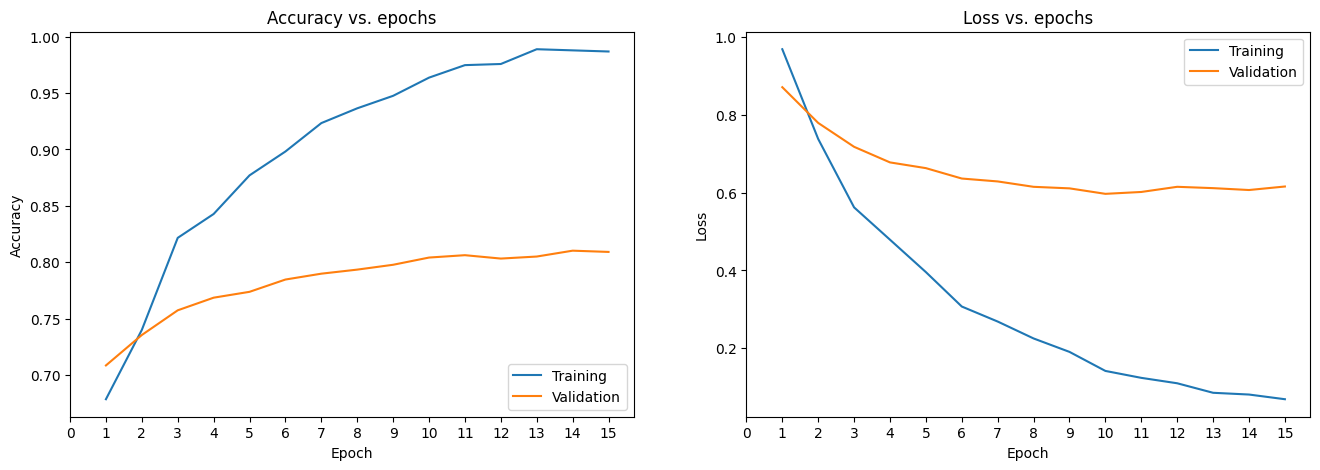

2022-08-18 20:13:05,394: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 11s 35ms/step


2022-08-18 20:13:42,161: INFO: test loss:0.6070
2022-08-18 20:13:42,162: INFO: test accuracy:0.8102
2022-08-18 20:13:42,166: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-18 20:13:42,169: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-18 20:13:42,170: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator
2022-08-18 20:13:42,171: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 12s 38ms/step


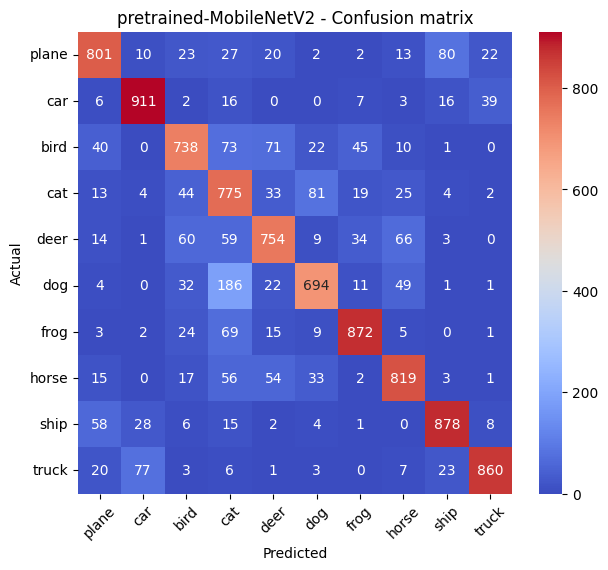

----------------------------------------models----------------------------------------


model_name                program_name  weight_number  \
1  pretrained-MobileNetV2  cifar10_0816_cnt_100.ipynb        1874250   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1       421.7  2022-08-18 20:13      0.0355      0.607           0.998   

   test_accuracy  train_auc  test_auc  
1         0.8102        1.0    0.9795

In [32]:
history = helper.train(model, epochs=15, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [33]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-18 20:13:55,071: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-18 20:13:55,073: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-18 20:13:55,074: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-18 20:13:55,075: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-18 20:13:55,077: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-18 20:13:55,078: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/ima

model_name                       program_name  weight_number  \
1   pretrained-MobileNetV2  cifar10_0816_cnt_5000_aug_1.ipynb        1874250   
2   pretrained-MobileNetV2        cifar10_0816_cnt_5000.ipynb        1874250   
3   pretrained-MobileNetV2    cifar10_0816_cnt_5000_aug.ipynb        1874250   
4   pretrained-MobileNetV2        cifar10_0816_cnt_2000.ipynb        1874250   
5   pretrained-MobileNetV2        cifar10_0816_cnt_1000.ipynb        1874250   
6                     vgg8        cifar10_0816_cnt_5000.ipynb        1672906   
7   pretrained-MobileNetV2         cifar10_0816_cnt_500.ipynb        1874250   
8   pretrained-MobileNetV2         cifar10_0816_cnt_200.ipynb        1874250   
9                     vgg8        cifar10_0816_cnt_2000.ipynb        1672906   
10            resnet_v1_20        cifar10_0816_cnt_5000.ipynb         273066   

    train_time       create_time  train_loss  test_loss  train_accuracy  \
1       1414.6  2022-08-17 05:31      0.1048     0.2324          0.9630   
2       1096.1  2022-08-16 12:32      0.0215     0.3150          0.9938   
3       1517.0  2022-08-17 06:29      0.1540     0.2510          0.9470   
4        762.3  2022-08-16 11:22      0.0112     0.4282          0.9976   
5        598.4  2022-08-16 09:26      0.0212     0.4112          0.9963   
6       2113.1  2022-08-16 11:13      0.0005     0.8218          0.9999   
7        487.0  2022-08-16 09:53      0.0125     0.4696          0.9992   
8        390.8  2022-08-18 20:13      0.0187     0.5293          0.9995   
9       1019.2  2022-08-16 10:31      0.0003     1.2263          1.0000   
10      2852.6  2022-08-16 12:02      0.1742     1.3372          0.9971   

    test_accuracy  train_auc  test_auc  
1          0.9312     0.9992    0.9967  
2          0.9260     1.0000    0.9964  
3          0.9199     0.9982    0.9958  
4          0.9058     1.0000    0.9944  
5          0.8930     1.0000    0.9929  
6          0.8845     1.0000    0.9893  
7          0.8778     1.0000    0.9906  
8          0.8469     0.9999    0.9866  
9          0.8299     1.0000    0.9791  
10         0.8207     1.0000    0.9796

In [34]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-18 20:13:55,160: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2
2022-08-18 20:14:05,426: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/val_test.generator
2022-08-18 20:14:05,449: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2
2022-08-18 20:14:15,515: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-08-18 20:14:15,536: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2
2022-08-18 20:14:26,309: INFO: load

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 1s 860ms/step


2022-08-18 20:14:50,131: WARNING: 5 out of the last 662 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fd67a30a700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 873ms/step


2022-08-18 20:14:51,049: WARNING: 6 out of the last 663 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fd67a14fd30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 18ms/step


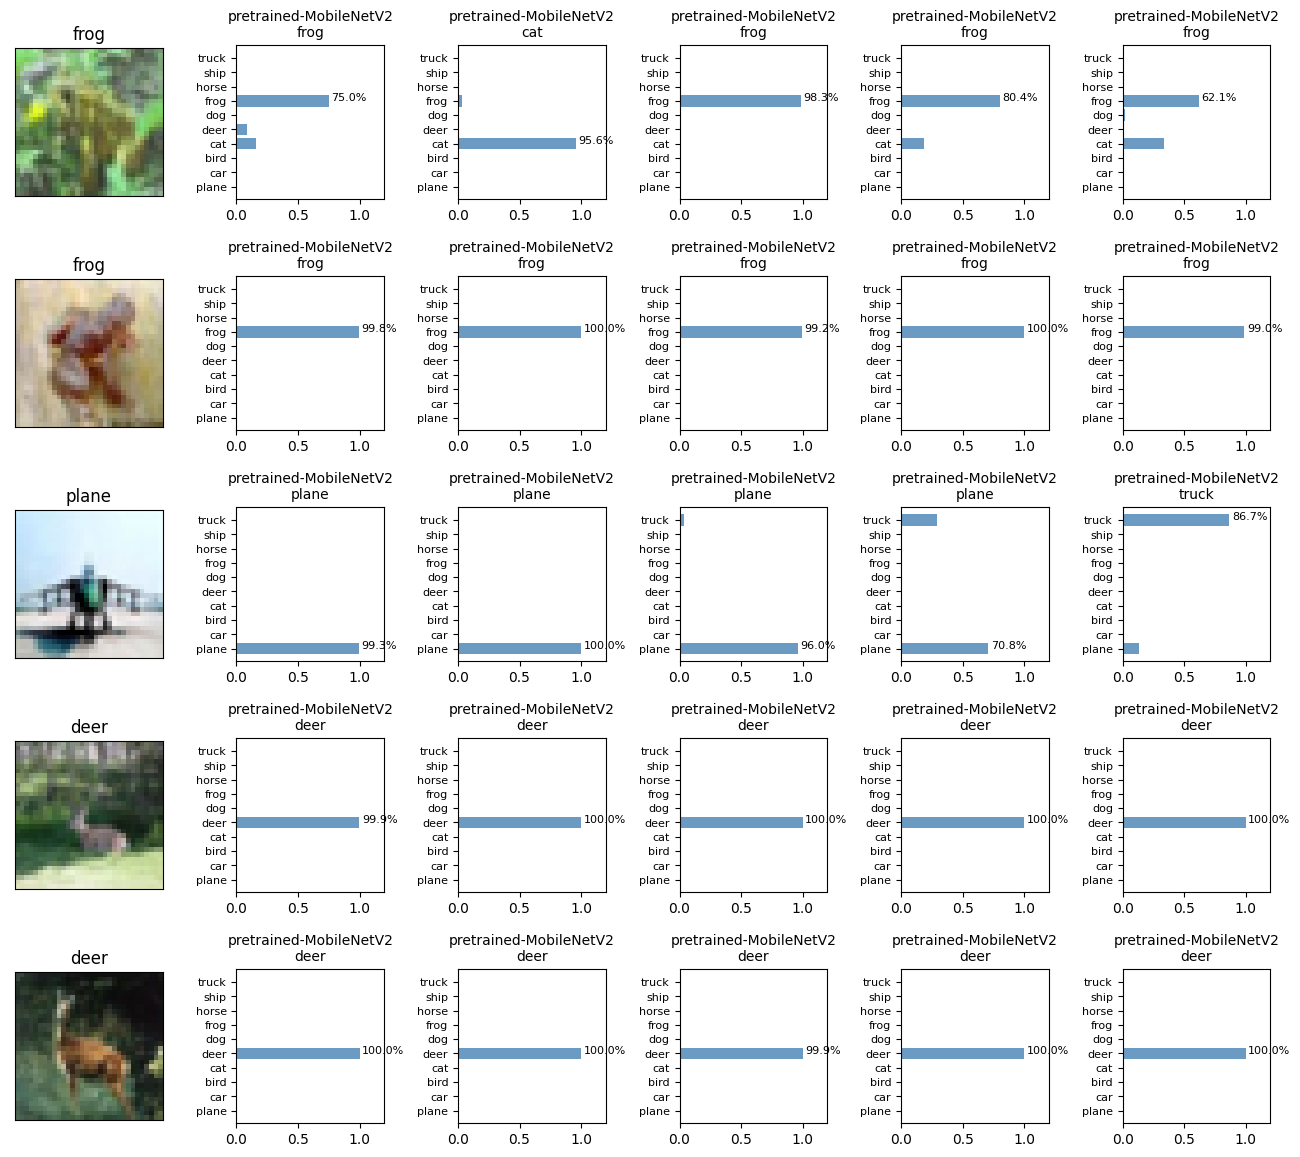

In [35]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 19ms/step


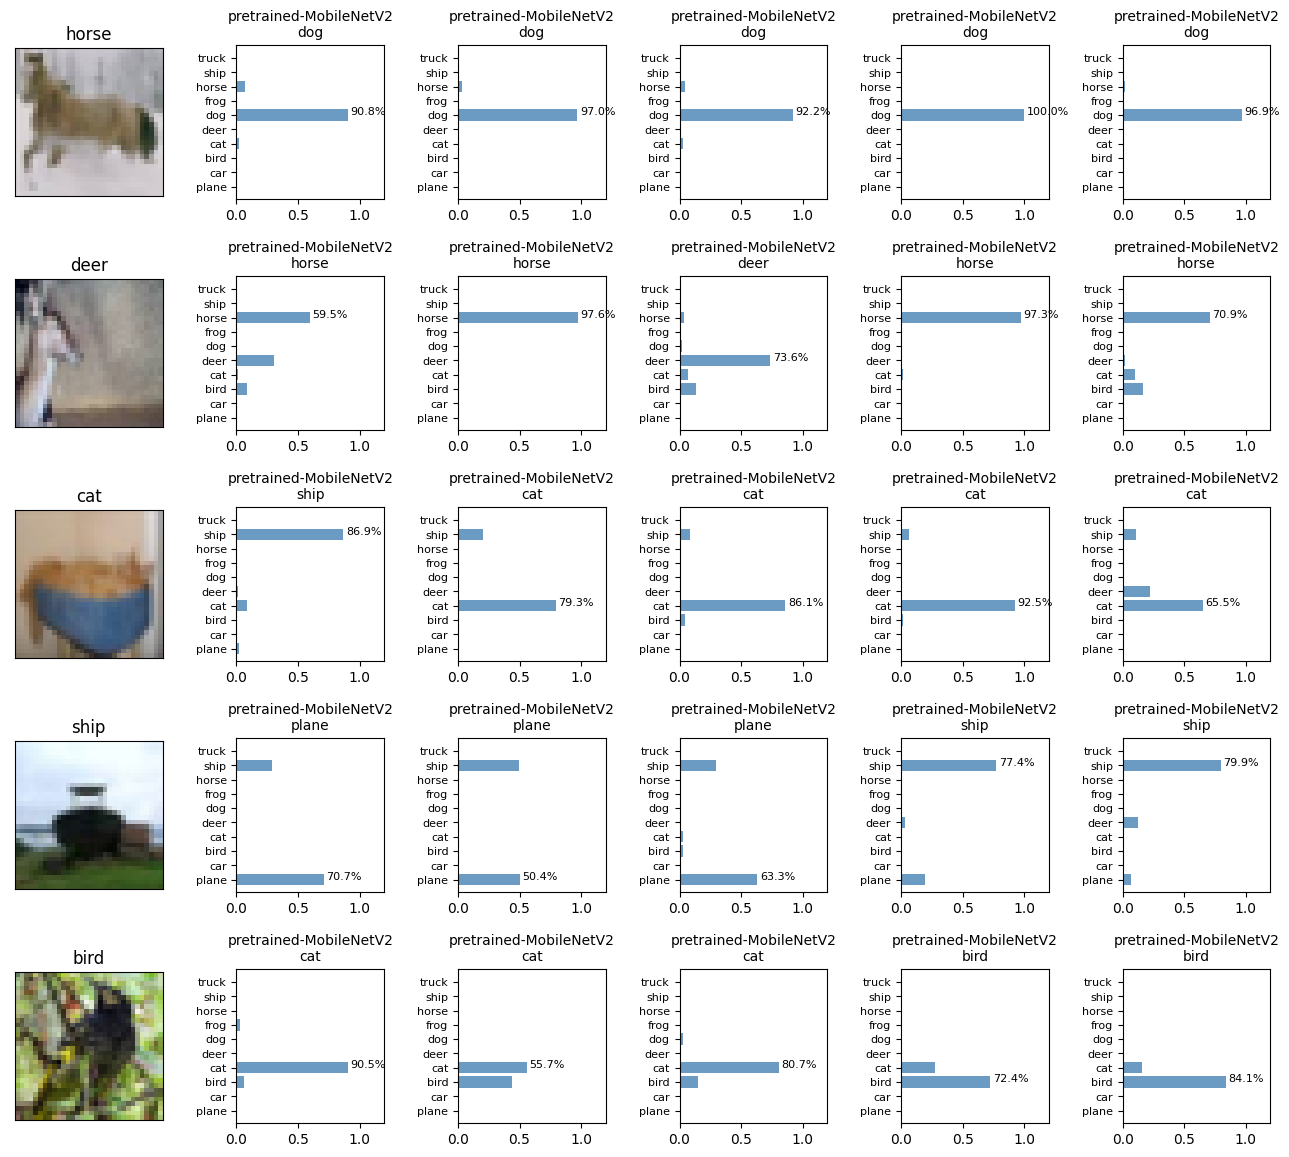

In [36]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [37]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.23238687217235565, 'accuracy': 0.9312000274658203, 'mae': 10.514875411987305}
313/313 [==============================] - 11s 37ms/step
(10000, 10)


In [38]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 12s 37ms/step


precision  recall        f1
plane   0.910462   0.966  0.937409
car     0.978659   0.963  0.970766
bird    0.940268   0.913  0.926433
cat     0.881799   0.843  0.861963
deer    0.892823   0.933  0.912469
dog     0.929806   0.861  0.894081
frog    0.913938   0.977  0.944418
horse   0.952333   0.939  0.945619
ship    0.971282   0.947  0.958987
truck   0.944499   0.970  0.957079

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9105    0.9660    0.9374      1000
         car     0.9787    0.9630    0.9708      1000
        bird     0.9403    0.9130    0.9264      1000
         cat     0.8818    0.8430    0.8620      1000
        deer     0.8928    0.9330    0.9125      1000
         dog     0.9298    0.8610    0.8941      1000
        frog     0.9139    0.9770    0.9444      1000
       horse     0.9523    0.9390    0.9456      1000
        ship     0.9713    0.9470    0.9590      1000
       truck     0.9445    0.9700    0.9571      1000

    accuracy                         0.9312     10000
   macro avg     0.9316    0.9312    0.9309     10000
weighted avg     0.9316    0.9312    0.9309     10000



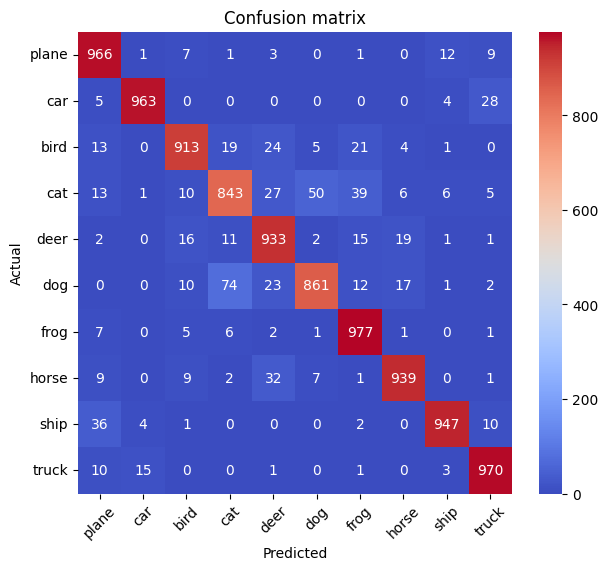

In [39]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)